In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
import os
import matplotlib.pyplot as plt

In [2]:
# For reproducible results
np.random.seed(0)

In [3]:
# Load the the csv file (BCa Wisconsin Diagnostic Data Set (Kaggle).csv)
BCa_address = '/Users/francybayona/Documents/DOC DIEGO/Python docs/Nanostic Project/BCa Wisconsin Diagnostic Data Set (Kaggle).csv'
df_BCa = pd.read_csv(BCa_address)
df_BCa.head(1)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,NaN


In [4]:
#Define train and target for TabNet
#Drop columns that are not part of the analysis: Unnamed: 32 and id
train = df_BCa.drop(['id', 'Unnamed: 32'],axis='columns')
target = 'diagnosis'

In [5]:
#Define the number of folds for the outer cross-validation
outer_cv_folds = 5

In [6]:
# Initialize probability variables for XGBoost
prob_train_XGBoost = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_XGBoost = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_XGBoost = np.full(outer_cv_folds, np.nan)
aucs_test_XGBoost = np.full(outer_cv_folds, np.nan)

In [7]:
# Initialize probability variables for TabNet
prob_train_TabNet = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_TabNet = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_TabNet = np.full(outer_cv_folds, np.nan)
aucs_test_TabNet = np.full(outer_cv_folds, np.nan)

In [8]:
# Use the function LabelEncoder for the column diagnosis
train['diagnosis'] = LabelEncoder().fit_transform(train['diagnosis'])
#Separate variables (x) from target (y) for XGBoost
x =  train.drop(['diagnosis'],axis='columns')
y = train.diagnosis

In [9]:
#Outer cross validation
cv_outer = StratifiedKFold(n_splits=outer_cv_folds)
ncv_idx = -1

for train_idx, test_idx in cv_outer.split(x, y):
    ncv_idx += 1
    train_data, test_data = x.iloc[train_idx], x.iloc[test_idx]
    train_target, test_target = y.iloc[train_idx], y.iloc[test_idx]
    XGBoost_model = XGBClassifier(objective = 'binary:logistic', # Add objective and metric to model initialization
                                  eval_metric = 'auc')
    # Find best XGBoost parameters
    cv_inner = StratifiedKFold(n_splits=3)   # Training data being split 3 times 
    Parmt_XGBoost = {'n_estimators':[50, 100],
                     'max_depth':[3, 5],
                     'learning_rate':[0.01, 0.1, 0.3],
                     'colsample_bytree':[0.5, 1],
                     'gamma':[0],
                     }
    
    Parmt_model_XGBoost = GridSearchCV(estimator=XGBoost_model,
                                       param_grid=Parmt_XGBoost,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_XGBoost = Parmt_model_XGBoost.best_params_
    # Set best parameters to XGBoost and Tabnet model
    XGBoost_model.set_params(**best_parameters_XGBoost)
    # Train optimized XGBoost model on train data
    XGBoost_model.fit(train_data,train_target)
    # Train data results
    prob_train_XGBoost[train_idx, ncv_idx] = XGBoost_model.predict_proba(train_data)[:,1]
    aucs_train_XGBoost[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_XGBoost[train_idx, ncv_idx])
    # Test data results
    prob_test_XGBoost[test_idx, ncv_idx] = XGBoost_model.predict_proba(test_data)[:,1]
    aucs_test_XGBoost[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_XGBoost[test_idx, ncv_idx])
    
    # Find best TabNet parameters
    TabNet_model = TabNetClassifier(cat_idxs=[])
    
    TabNet_model.fit(X_train=train_data.to_numpy(),  
            y_train=train_target.to_numpy(), 
            eval_set=[(train_data.to_numpy(), train_target.to_numpy())], 
            eval_name=['train'], 
            eval_metric=['auc'],
            max_epochs=2000, 
            patience=2000,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False)

    # Train data results
    prob_train_TabNet[train_idx, ncv_idx] = TabNet_model.predict_proba(train_data.to_numpy())[:,1]
    aucs_train_TabNet[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_TabNet[train_idx, ncv_idx])
    # Test data results
    prob_test_TabNet[test_idx, ncv_idx] = TabNet_model.predict_proba(test_data.to_numpy())[:,1]
    aucs_test_TabNet[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_TabNet[test_idx, ncv_idx])

Device used : cpu
epoch 0  | loss: 0.97081 | train_auc: 0.50423 |  0:00:00s
epoch 1  | loss: 0.78256 | train_auc: 0.65914 |  0:00:00s
epoch 2  | loss: 0.62331 | train_auc: 0.69974 |  0:00:00s
epoch 3  | loss: 0.53361 | train_auc: 0.65031 |  0:00:00s
epoch 4  | loss: 0.46774 | train_auc: 0.66736 |  0:00:00s
epoch 5  | loss: 0.47305 | train_auc: 0.56937 |  0:00:00s
epoch 6  | loss: 0.39797 | train_auc: 0.33821 |  0:00:00s
epoch 7  | loss: 0.34264 | train_auc: 0.32375 |  0:00:00s
epoch 8  | loss: 0.31548 | train_auc: 0.82836 |  0:00:00s
epoch 9  | loss: 0.28614 | train_auc: 0.82184 |  0:00:00s
epoch 10 | loss: 0.27435 | train_auc: 0.8162  |  0:00:00s
epoch 11 | loss: 0.2385  | train_auc: 0.77676 |  0:00:00s
epoch 12 | loss: 0.21097 | train_auc: 0.68285 |  0:00:00s
epoch 13 | loss: 0.18833 | train_auc: 0.60294 |  0:00:00s
epoch 14 | loss: 0.18014 | train_auc: 0.49034 |  0:00:00s
epoch 15 | loss: 0.16933 | train_auc: 0.44328 |  0:00:01s
epoch 16 | loss: 0.14202 | train_auc: 0.46991 |  0:00:

epoch 144| loss: 0.04237 | train_auc: 0.95036 |  0:00:09s
epoch 145| loss: 0.01977 | train_auc: 0.94985 |  0:00:09s
epoch 146| loss: 0.03025 | train_auc: 0.94748 |  0:00:09s
epoch 147| loss: 0.01606 | train_auc: 0.94488 |  0:00:09s
epoch 148| loss: 0.0387  | train_auc: 0.94304 |  0:00:09s
epoch 149| loss: 0.01674 | train_auc: 0.94425 |  0:00:09s
epoch 150| loss: 0.03106 | train_auc: 0.94562 |  0:00:09s
epoch 151| loss: 0.03057 | train_auc: 0.94857 |  0:00:09s
epoch 152| loss: 0.02388 | train_auc: 0.94811 |  0:00:09s
epoch 153| loss: 0.01641 | train_auc: 0.94896 |  0:00:10s
epoch 154| loss: 0.03169 | train_auc: 0.94881 |  0:00:10s
epoch 155| loss: 0.01027 | train_auc: 0.94777 |  0:00:10s
epoch 156| loss: 0.02488 | train_auc: 0.94852 |  0:00:10s
epoch 157| loss: 0.01246 | train_auc: 0.94678 |  0:00:10s
epoch 158| loss: 0.01497 | train_auc: 0.94431 |  0:00:10s
epoch 159| loss: 0.01751 | train_auc: 0.94318 |  0:00:10s
epoch 160| loss: 0.01211 | train_auc: 0.94266 |  0:00:10s
epoch 161| los

epoch 288| loss: 0.00352 | train_auc: 0.98651 |  0:00:20s
epoch 289| loss: 0.00346 | train_auc: 0.98684 |  0:00:20s
epoch 290| loss: 0.00221 | train_auc: 0.98686 |  0:00:20s
epoch 291| loss: 0.00523 | train_auc: 0.98695 |  0:00:20s
epoch 292| loss: 0.00364 | train_auc: 0.98692 |  0:00:20s
epoch 293| loss: 0.00298 | train_auc: 0.9869  |  0:00:20s
epoch 294| loss: 0.00246 | train_auc: 0.98701 |  0:00:20s
epoch 295| loss: 0.00546 | train_auc: 0.98701 |  0:00:20s
epoch 296| loss: 0.01498 | train_auc: 0.9867  |  0:00:20s
epoch 297| loss: 0.01407 | train_auc: 0.98558 |  0:00:20s
epoch 298| loss: 0.01241 | train_auc: 0.98512 |  0:00:20s
epoch 299| loss: 0.00523 | train_auc: 0.9845  |  0:00:20s
epoch 300| loss: 0.01017 | train_auc: 0.98363 |  0:00:20s
epoch 301| loss: 0.0121  | train_auc: 0.9831  |  0:00:20s
epoch 302| loss: 0.00645 | train_auc: 0.98337 |  0:00:21s
epoch 303| loss: 0.00224 | train_auc: 0.98386 |  0:00:21s
epoch 304| loss: 0.0016  | train_auc: 0.98392 |  0:00:21s
epoch 305| los

epoch 432| loss: 0.01131 | train_auc: 0.99441 |  0:00:30s
epoch 433| loss: 0.00185 | train_auc: 0.9941  |  0:00:30s
epoch 434| loss: 0.00538 | train_auc: 0.99377 |  0:00:30s
epoch 435| loss: 0.00339 | train_auc: 0.99371 |  0:00:30s
epoch 436| loss: 0.00145 | train_auc: 0.99377 |  0:00:30s
epoch 437| loss: 0.00341 | train_auc: 0.99377 |  0:00:30s
epoch 438| loss: 0.00924 | train_auc: 0.99406 |  0:00:31s
epoch 439| loss: 0.00614 | train_auc: 0.99427 |  0:00:31s
epoch 440| loss: 0.0021  | train_auc: 0.99412 |  0:00:31s
epoch 441| loss: 0.00122 | train_auc: 0.99423 |  0:00:31s
epoch 442| loss: 0.00586 | train_auc: 0.99425 |  0:00:31s
epoch 443| loss: 0.00737 | train_auc: 0.99446 |  0:00:31s
epoch 444| loss: 0.00412 | train_auc: 0.99466 |  0:00:31s
epoch 445| loss: 0.01071 | train_auc: 0.99456 |  0:00:31s
epoch 446| loss: 0.01619 | train_auc: 0.99454 |  0:00:31s
epoch 447| loss: 0.00552 | train_auc: 0.99468 |  0:00:31s
epoch 448| loss: 0.00284 | train_auc: 0.99495 |  0:00:31s
epoch 449| los

epoch 575| loss: 0.02115 | train_auc: 0.99294 |  0:00:41s
epoch 576| loss: 0.01508 | train_auc: 0.99257 |  0:00:41s
epoch 577| loss: 0.01442 | train_auc: 0.99206 |  0:00:41s
epoch 578| loss: 0.02664 | train_auc: 0.99156 |  0:00:41s
epoch 579| loss: 0.00832 | train_auc: 0.99162 |  0:00:41s
epoch 580| loss: 0.00415 | train_auc: 0.99164 |  0:00:41s
epoch 581| loss: 0.00544 | train_auc: 0.99168 |  0:00:41s
epoch 582| loss: 0.00575 | train_auc: 0.99185 |  0:00:41s
epoch 583| loss: 0.01078 | train_auc: 0.99199 |  0:00:41s
epoch 584| loss: 0.01578 | train_auc: 0.99206 |  0:00:41s
epoch 585| loss: 0.00655 | train_auc: 0.99206 |  0:00:41s
epoch 586| loss: 0.00658 | train_auc: 0.99197 |  0:00:41s
epoch 587| loss: 0.00284 | train_auc: 0.99203 |  0:00:41s
epoch 588| loss: 0.01055 | train_auc: 0.99221 |  0:00:41s
epoch 589| loss: 0.00837 | train_auc: 0.99226 |  0:00:41s
epoch 590| loss: 0.01486 | train_auc: 0.99164 |  0:00:42s
epoch 591| loss: 0.00866 | train_auc: 0.99135 |  0:00:42s
epoch 592| los

epoch 718| loss: 0.00558 | train_auc: 0.99487 |  0:00:50s
epoch 719| loss: 0.00358 | train_auc: 0.99489 |  0:00:50s
epoch 720| loss: 0.00087 | train_auc: 0.99481 |  0:00:50s
epoch 721| loss: 0.00241 | train_auc: 0.99481 |  0:00:50s
epoch 722| loss: 0.00086 | train_auc: 0.99472 |  0:00:50s
epoch 723| loss: 0.00125 | train_auc: 0.99468 |  0:00:51s
epoch 724| loss: 0.00708 | train_auc: 0.99464 |  0:00:51s
epoch 725| loss: 0.00216 | train_auc: 0.99454 |  0:00:51s
epoch 726| loss: 0.00176 | train_auc: 0.99452 |  0:00:51s
epoch 727| loss: 0.00635 | train_auc: 0.99443 |  0:00:51s
epoch 728| loss: 0.00113 | train_auc: 0.99437 |  0:00:51s
epoch 729| loss: 0.00172 | train_auc: 0.99437 |  0:00:51s
epoch 730| loss: 0.00122 | train_auc: 0.99431 |  0:00:51s
epoch 731| loss: 0.00132 | train_auc: 0.99427 |  0:00:51s
epoch 732| loss: 0.00156 | train_auc: 0.99421 |  0:00:51s
epoch 733| loss: 0.00452 | train_auc: 0.99433 |  0:00:51s
epoch 734| loss: 0.00141 | train_auc: 0.99448 |  0:00:51s
epoch 735| los

epoch 862| loss: 0.00513 | train_auc: 0.99661 |  0:01:00s
epoch 863| loss: 0.00092 | train_auc: 0.99671 |  0:01:00s
epoch 864| loss: 0.00178 | train_auc: 0.99677 |  0:01:00s
epoch 865| loss: 0.00174 | train_auc: 0.99688 |  0:01:00s
epoch 866| loss: 0.00101 | train_auc: 0.9969  |  0:01:00s
epoch 867| loss: 0.00056 | train_auc: 0.99698 |  0:01:00s
epoch 868| loss: 0.00066 | train_auc: 0.99704 |  0:01:00s
epoch 869| loss: 0.00062 | train_auc: 0.99712 |  0:01:00s
epoch 870| loss: 0.00055 | train_auc: 0.99721 |  0:01:01s
epoch 871| loss: 0.00102 | train_auc: 0.99731 |  0:01:01s
epoch 872| loss: 0.0007  | train_auc: 0.99733 |  0:01:01s
epoch 873| loss: 0.00108 | train_auc: 0.99737 |  0:01:01s
epoch 874| loss: 0.00168 | train_auc: 0.99746 |  0:01:01s
epoch 875| loss: 0.00086 | train_auc: 0.99748 |  0:01:01s
epoch 876| loss: 0.00056 | train_auc: 0.9975  |  0:01:01s
epoch 877| loss: 0.00067 | train_auc: 0.99762 |  0:01:01s
epoch 878| loss: 0.00073 | train_auc: 0.99764 |  0:01:01s
epoch 879| los

epoch 1005| loss: 0.00142 | train_auc: 1.0     |  0:01:10s
epoch 1006| loss: 0.00161 | train_auc: 1.0     |  0:01:10s
epoch 1007| loss: 0.00345 | train_auc: 1.0     |  0:01:10s
epoch 1008| loss: 0.00092 | train_auc: 1.0     |  0:01:10s
epoch 1009| loss: 0.00139 | train_auc: 1.0     |  0:01:10s
epoch 1010| loss: 0.00168 | train_auc: 1.0     |  0:01:10s
epoch 1011| loss: 0.00345 | train_auc: 1.0     |  0:01:10s
epoch 1012| loss: 0.00149 | train_auc: 1.0     |  0:01:10s
epoch 1013| loss: 0.00245 | train_auc: 1.0     |  0:01:10s
epoch 1014| loss: 0.00123 | train_auc: 1.0     |  0:01:11s
epoch 1015| loss: 0.00094 | train_auc: 1.0     |  0:01:11s
epoch 1016| loss: 0.00612 | train_auc: 1.0     |  0:01:11s
epoch 1017| loss: 0.0008  | train_auc: 1.0     |  0:01:11s
epoch 1018| loss: 0.00122 | train_auc: 1.0     |  0:01:11s
epoch 1019| loss: 0.00256 | train_auc: 1.0     |  0:01:11s
epoch 1020| loss: 0.00603 | train_auc: 1.0     |  0:01:11s
epoch 1021| loss: 0.0009  | train_auc: 1.0     |  0:01:1

epoch 1146| loss: 0.0057  | train_auc: 1.0     |  0:01:19s
epoch 1147| loss: 0.00103 | train_auc: 1.0     |  0:01:19s
epoch 1148| loss: 0.00116 | train_auc: 1.0     |  0:01:19s
epoch 1149| loss: 0.00049 | train_auc: 1.0     |  0:01:20s
epoch 1150| loss: 0.00124 | train_auc: 1.0     |  0:01:20s
epoch 1151| loss: 0.0036  | train_auc: 1.0     |  0:01:20s
epoch 1152| loss: 0.00305 | train_auc: 1.0     |  0:01:20s
epoch 1153| loss: 0.0007  | train_auc: 1.0     |  0:01:20s
epoch 1154| loss: 0.0021  | train_auc: 1.0     |  0:01:20s
epoch 1155| loss: 0.00288 | train_auc: 1.0     |  0:01:20s
epoch 1156| loss: 0.00553 | train_auc: 1.0     |  0:01:20s
epoch 1157| loss: 0.00135 | train_auc: 1.0     |  0:01:20s
epoch 1158| loss: 0.00079 | train_auc: 1.0     |  0:01:20s
epoch 1159| loss: 0.00058 | train_auc: 1.0     |  0:01:20s
epoch 1160| loss: 0.00435 | train_auc: 1.0     |  0:01:20s
epoch 1161| loss: 0.00067 | train_auc: 1.0     |  0:01:20s
epoch 1162| loss: 0.00121 | train_auc: 1.0     |  0:01:2

epoch 1286| loss: 0.00446 | train_auc: 1.0     |  0:01:29s
epoch 1287| loss: 0.00321 | train_auc: 1.0     |  0:01:29s
epoch 1288| loss: 0.00231 | train_auc: 1.0     |  0:01:29s
epoch 1289| loss: 0.00204 | train_auc: 1.0     |  0:01:29s
epoch 1290| loss: 0.00898 | train_auc: 1.0     |  0:01:29s
epoch 1291| loss: 0.00236 | train_auc: 1.0     |  0:01:29s
epoch 1292| loss: 0.01856 | train_auc: 1.0     |  0:01:29s
epoch 1293| loss: 0.00953 | train_auc: 1.0     |  0:01:29s
epoch 1294| loss: 0.00333 | train_auc: 1.0     |  0:01:29s
epoch 1295| loss: 0.00179 | train_auc: 1.0     |  0:01:29s
epoch 1296| loss: 0.00621 | train_auc: 1.0     |  0:01:30s
epoch 1297| loss: 0.0038  | train_auc: 1.0     |  0:01:30s
epoch 1298| loss: 0.00246 | train_auc: 1.0     |  0:01:30s
epoch 1299| loss: 0.00176 | train_auc: 1.0     |  0:01:30s
epoch 1300| loss: 0.00699 | train_auc: 1.0     |  0:01:30s
epoch 1301| loss: 0.00185 | train_auc: 1.0     |  0:01:30s
epoch 1302| loss: 0.00628 | train_auc: 1.0     |  0:01:3

epoch 1426| loss: 0.00072 | train_auc: 1.0     |  0:01:38s
epoch 1427| loss: 0.00087 | train_auc: 1.0     |  0:01:39s
epoch 1428| loss: 0.01723 | train_auc: 1.0     |  0:01:39s
epoch 1429| loss: 0.00635 | train_auc: 1.0     |  0:01:39s
epoch 1430| loss: 0.00117 | train_auc: 1.0     |  0:01:39s
epoch 1431| loss: 0.00184 | train_auc: 1.0     |  0:01:39s
epoch 1432| loss: 0.00223 | train_auc: 1.0     |  0:01:39s
epoch 1433| loss: 0.00061 | train_auc: 1.0     |  0:01:39s
epoch 1434| loss: 0.00074 | train_auc: 1.0     |  0:01:39s
epoch 1435| loss: 0.01054 | train_auc: 1.0     |  0:01:39s
epoch 1436| loss: 0.0045  | train_auc: 1.0     |  0:01:39s
epoch 1437| loss: 0.00249 | train_auc: 1.0     |  0:01:39s
epoch 1438| loss: 0.0006  | train_auc: 1.0     |  0:01:39s
epoch 1439| loss: 0.00065 | train_auc: 1.0     |  0:01:39s
epoch 1440| loss: 0.00055 | train_auc: 1.0     |  0:01:39s
epoch 1441| loss: 0.00061 | train_auc: 1.0     |  0:01:40s
epoch 1442| loss: 0.01744 | train_auc: 1.0     |  0:01:4

epoch 1566| loss: 0.03348 | train_auc: 1.0     |  0:01:48s
epoch 1567| loss: 0.00084 | train_auc: 1.0     |  0:01:48s
epoch 1568| loss: 0.00119 | train_auc: 1.0     |  0:01:48s
epoch 1569| loss: 0.00079 | train_auc: 1.0     |  0:01:48s
epoch 1570| loss: 0.00077 | train_auc: 1.0     |  0:01:48s
epoch 1571| loss: 0.00248 | train_auc: 1.0     |  0:01:48s
epoch 1572| loss: 0.00409 | train_auc: 1.0     |  0:01:48s
epoch 1573| loss: 0.00205 | train_auc: 1.0     |  0:01:49s
epoch 1574| loss: 0.00224 | train_auc: 1.0     |  0:01:49s
epoch 1575| loss: 0.00157 | train_auc: 1.0     |  0:01:49s
epoch 1576| loss: 0.00144 | train_auc: 1.0     |  0:01:49s
epoch 1577| loss: 0.00176 | train_auc: 1.0     |  0:01:49s
epoch 1578| loss: 0.00072 | train_auc: 1.0     |  0:01:49s
epoch 1579| loss: 0.00093 | train_auc: 1.0     |  0:01:49s
epoch 1580| loss: 0.00054 | train_auc: 1.0     |  0:01:49s
epoch 1581| loss: 0.00085 | train_auc: 1.0     |  0:01:49s
epoch 1582| loss: 0.00081 | train_auc: 1.0     |  0:01:4

epoch 1707| loss: 0.00042 | train_auc: 1.0     |  0:01:57s
epoch 1708| loss: 0.00034 | train_auc: 1.0     |  0:01:58s
epoch 1709| loss: 0.00032 | train_auc: 1.0     |  0:01:58s
epoch 1710| loss: 0.00061 | train_auc: 1.0     |  0:01:58s
epoch 1711| loss: 0.00035 | train_auc: 1.0     |  0:01:58s
epoch 1712| loss: 0.0004  | train_auc: 1.0     |  0:01:58s
epoch 1713| loss: 0.00036 | train_auc: 1.0     |  0:01:58s
epoch 1714| loss: 0.00057 | train_auc: 1.0     |  0:01:58s
epoch 1715| loss: 0.00045 | train_auc: 1.0     |  0:01:58s
epoch 1716| loss: 0.0003  | train_auc: 1.0     |  0:01:58s
epoch 1717| loss: 0.00035 | train_auc: 1.0     |  0:01:58s
epoch 1718| loss: 0.0003  | train_auc: 1.0     |  0:01:58s
epoch 1719| loss: 0.00221 | train_auc: 1.0     |  0:01:58s
epoch 1720| loss: 0.00036 | train_auc: 1.0     |  0:01:58s
epoch 1721| loss: 0.00296 | train_auc: 1.0     |  0:01:58s
epoch 1722| loss: 0.00028 | train_auc: 1.0     |  0:01:58s
epoch 1723| loss: 0.0003  | train_auc: 1.0     |  0:01:5

epoch 1846| loss: 0.00377 | train_auc: 1.0     |  0:02:07s
epoch 1847| loss: 0.01236 | train_auc: 1.0     |  0:02:07s
epoch 1848| loss: 0.00109 | train_auc: 1.0     |  0:02:07s
epoch 1849| loss: 0.00127 | train_auc: 1.0     |  0:02:07s
epoch 1850| loss: 0.00233 | train_auc: 1.0     |  0:02:07s
epoch 1851| loss: 0.00174 | train_auc: 1.0     |  0:02:07s
epoch 1852| loss: 0.0288  | train_auc: 1.0     |  0:02:07s
epoch 1853| loss: 0.00308 | train_auc: 1.0     |  0:02:07s
epoch 1854| loss: 0.00436 | train_auc: 1.0     |  0:02:07s
epoch 1855| loss: 0.00363 | train_auc: 1.0     |  0:02:08s
epoch 1856| loss: 0.00569 | train_auc: 1.0     |  0:02:08s
epoch 1857| loss: 0.00065 | train_auc: 1.0     |  0:02:08s
epoch 1858| loss: 0.00065 | train_auc: 1.0     |  0:02:08s
epoch 1859| loss: 0.00337 | train_auc: 1.0     |  0:02:08s
epoch 1860| loss: 0.00103 | train_auc: 1.0     |  0:02:08s
epoch 1861| loss: 0.00201 | train_auc: 1.0     |  0:02:08s
epoch 1862| loss: 0.00058 | train_auc: 1.0     |  0:02:0

epoch 1985| loss: 0.00081 | train_auc: 1.0     |  0:02:16s
epoch 1986| loss: 0.00072 | train_auc: 1.0     |  0:02:17s
epoch 1987| loss: 0.00059 | train_auc: 1.0     |  0:02:17s
epoch 1988| loss: 0.00043 | train_auc: 1.0     |  0:02:17s
epoch 1989| loss: 0.00097 | train_auc: 1.0     |  0:02:17s
epoch 1990| loss: 0.00047 | train_auc: 1.0     |  0:02:17s
epoch 1991| loss: 0.00042 | train_auc: 1.0     |  0:02:17s
epoch 1992| loss: 0.0004  | train_auc: 1.0     |  0:02:17s
epoch 1993| loss: 0.00038 | train_auc: 1.0     |  0:02:17s
epoch 1994| loss: 0.00054 | train_auc: 1.0     |  0:02:17s
epoch 1995| loss: 0.00041 | train_auc: 1.0     |  0:02:17s
epoch 1996| loss: 0.00182 | train_auc: 1.0     |  0:02:17s
epoch 1997| loss: 0.00031 | train_auc: 1.0     |  0:02:17s
epoch 1998| loss: 0.00045 | train_auc: 1.0     |  0:02:17s
epoch 1999| loss: 0.00033 | train_auc: 1.0     |  0:02:17s
Stop training because you reached max_epochs = 2000 with best_epoch = 923 and best_train_auc = 1.0
Best weights fro

epoch 125| loss: 0.04007 | train_auc: 0.89856 |  0:00:08s
epoch 126| loss: 0.01391 | train_auc: 0.89344 |  0:00:08s
epoch 127| loss: 0.0153  | train_auc: 0.89195 |  0:00:08s
epoch 128| loss: 0.00907 | train_auc: 0.89117 |  0:00:08s
epoch 129| loss: 0.01076 | train_auc: 0.88901 |  0:00:08s
epoch 130| loss: 0.02313 | train_auc: 0.89203 |  0:00:08s
epoch 131| loss: 0.01551 | train_auc: 0.89582 |  0:00:08s
epoch 132| loss: 0.01617 | train_auc: 0.90059 |  0:00:08s
epoch 133| loss: 0.00651 | train_auc: 0.90491 |  0:00:09s
epoch 134| loss: 0.0106  | train_auc: 0.90696 |  0:00:09s
epoch 135| loss: 0.0089  | train_auc: 0.91069 |  0:00:09s
epoch 136| loss: 0.05301 | train_auc: 0.91518 |  0:00:09s
epoch 137| loss: 0.0117  | train_auc: 0.91764 |  0:00:09s
epoch 138| loss: 0.01634 | train_auc: 0.91716 |  0:00:09s
epoch 139| loss: 0.03145 | train_auc: 0.91352 |  0:00:09s
epoch 140| loss: 0.03839 | train_auc: 0.91038 |  0:00:09s
epoch 141| loss: 0.01907 | train_auc: 0.90538 |  0:00:09s
epoch 142| los

epoch 269| loss: 0.00167 | train_auc: 0.99127 |  0:00:18s
epoch 270| loss: 0.00563 | train_auc: 0.99156 |  0:00:18s
epoch 271| loss: 0.00253 | train_auc: 0.9916  |  0:00:18s
epoch 272| loss: 0.00311 | train_auc: 0.99184 |  0:00:18s
epoch 273| loss: 0.00193 | train_auc: 0.99186 |  0:00:18s
epoch 274| loss: 0.00436 | train_auc: 0.99271 |  0:00:18s
epoch 275| loss: 0.00204 | train_auc: 0.99269 |  0:00:18s
epoch 276| loss: 0.00245 | train_auc: 0.99266 |  0:00:18s
epoch 277| loss: 0.00152 | train_auc: 0.99289 |  0:00:18s
epoch 278| loss: 0.00382 | train_auc: 0.99335 |  0:00:18s
epoch 279| loss: 0.00157 | train_auc: 0.99354 |  0:00:19s
epoch 280| loss: 0.00883 | train_auc: 0.99351 |  0:00:19s
epoch 281| loss: 0.00148 | train_auc: 0.99362 |  0:00:19s
epoch 282| loss: 0.00142 | train_auc: 0.99369 |  0:00:19s
epoch 283| loss: 0.00188 | train_auc: 0.99368 |  0:00:19s
epoch 284| loss: 0.00151 | train_auc: 0.99364 |  0:00:19s
epoch 285| loss: 0.00153 | train_auc: 0.99359 |  0:00:19s
epoch 286| los

epoch 411| loss: 0.00092 | train_auc: 0.99692 |  0:00:28s
epoch 412| loss: 0.0055  | train_auc: 0.99727 |  0:00:28s
epoch 413| loss: 0.0039  | train_auc: 0.99754 |  0:00:28s
epoch 414| loss: 0.00751 | train_auc: 0.99752 |  0:00:28s
epoch 415| loss: 0.00161 | train_auc: 0.99735 |  0:00:28s
epoch 416| loss: 0.004   | train_auc: 0.99719 |  0:00:28s
epoch 417| loss: 0.00885 | train_auc: 0.99712 |  0:00:28s
epoch 418| loss: 0.00122 | train_auc: 0.99706 |  0:00:28s
epoch 419| loss: 0.00146 | train_auc: 0.99694 |  0:00:28s
epoch 420| loss: 0.00108 | train_auc: 0.99679 |  0:00:28s
epoch 421| loss: 0.00109 | train_auc: 0.99669 |  0:00:28s
epoch 422| loss: 0.00341 | train_auc: 0.99669 |  0:00:29s
epoch 423| loss: 0.01097 | train_auc: 0.99659 |  0:00:29s
epoch 424| loss: 0.00154 | train_auc: 0.9965  |  0:00:29s
epoch 425| loss: 0.00245 | train_auc: 0.99628 |  0:00:29s
epoch 426| loss: 0.00214 | train_auc: 0.99613 |  0:00:29s
epoch 427| loss: 0.00091 | train_auc: 0.99599 |  0:00:29s
epoch 428| los

epoch 554| loss: 0.00575 | train_auc: 0.99623 |  0:00:38s
epoch 555| loss: 0.00103 | train_auc: 0.99654 |  0:00:38s
epoch 556| loss: 0.00158 | train_auc: 0.99686 |  0:00:38s
epoch 557| loss: 0.00223 | train_auc: 0.99719 |  0:00:38s
epoch 558| loss: 0.00163 | train_auc: 0.99748 |  0:00:38s
epoch 559| loss: 0.00103 | train_auc: 0.99768 |  0:00:38s
epoch 560| loss: 0.00094 | train_auc: 0.99779 |  0:00:39s
epoch 561| loss: 0.00128 | train_auc: 0.99787 |  0:00:39s
epoch 562| loss: 0.00169 | train_auc: 0.99779 |  0:00:39s
epoch 563| loss: 0.00073 | train_auc: 0.99781 |  0:00:39s
epoch 564| loss: 0.00111 | train_auc: 0.99783 |  0:00:39s
epoch 565| loss: 0.0013  | train_auc: 0.99781 |  0:00:39s
epoch 566| loss: 0.00097 | train_auc: 0.99779 |  0:00:39s
epoch 567| loss: 0.00602 | train_auc: 0.99781 |  0:00:39s
epoch 568| loss: 0.00075 | train_auc: 0.99772 |  0:00:39s
epoch 569| loss: 0.00064 | train_auc: 0.99772 |  0:00:39s
epoch 570| loss: 0.00125 | train_auc: 0.99762 |  0:00:39s
epoch 571| los

epoch 697| loss: 0.00229 | train_auc: 0.99601 |  0:00:48s
epoch 698| loss: 0.00278 | train_auc: 0.99592 |  0:00:48s
epoch 699| loss: 0.00388 | train_auc: 0.99607 |  0:00:48s
epoch 700| loss: 0.00147 | train_auc: 0.99615 |  0:00:48s
epoch 701| loss: 0.00176 | train_auc: 0.99619 |  0:00:48s
epoch 702| loss: 0.00271 | train_auc: 0.99628 |  0:00:48s
epoch 703| loss: 0.00532 | train_auc: 0.99638 |  0:00:48s
epoch 704| loss: 0.00202 | train_auc: 0.99652 |  0:00:48s
epoch 705| loss: 0.00097 | train_auc: 0.99665 |  0:00:48s
epoch 706| loss: 0.00118 | train_auc: 0.99669 |  0:00:48s
epoch 707| loss: 0.00117 | train_auc: 0.99675 |  0:00:49s
epoch 708| loss: 0.00115 | train_auc: 0.99686 |  0:00:49s
epoch 709| loss: 0.00219 | train_auc: 0.99712 |  0:00:49s
epoch 710| loss: 0.00274 | train_auc: 0.99756 |  0:00:49s
epoch 711| loss: 0.0013  | train_auc: 0.99766 |  0:00:49s
epoch 712| loss: 0.00468 | train_auc: 0.99774 |  0:00:49s
epoch 713| loss: 0.00187 | train_auc: 0.99785 |  0:00:49s
epoch 714| los

epoch 841| loss: 0.00112 | train_auc: 0.99892 |  0:00:58s
epoch 842| loss: 0.00121 | train_auc: 0.99892 |  0:00:58s
epoch 843| loss: 0.00149 | train_auc: 0.99894 |  0:00:58s
epoch 844| loss: 0.00175 | train_auc: 0.99897 |  0:00:58s
epoch 845| loss: 0.00082 | train_auc: 0.99894 |  0:00:58s
epoch 846| loss: 0.00178 | train_auc: 0.99894 |  0:00:58s
epoch 847| loss: 0.00071 | train_auc: 0.99894 |  0:00:58s
epoch 848| loss: 0.0008  | train_auc: 0.99892 |  0:00:58s
epoch 849| loss: 0.00123 | train_auc: 0.99892 |  0:00:58s
epoch 850| loss: 0.0007  | train_auc: 0.99892 |  0:00:59s
epoch 851| loss: 0.00084 | train_auc: 0.99892 |  0:00:59s
epoch 852| loss: 0.00074 | train_auc: 0.99892 |  0:00:59s
epoch 853| loss: 0.00103 | train_auc: 0.99894 |  0:00:59s
epoch 854| loss: 0.00135 | train_auc: 0.99892 |  0:00:59s
epoch 855| loss: 0.00072 | train_auc: 0.99892 |  0:00:59s
epoch 856| loss: 0.00108 | train_auc: 0.99892 |  0:00:59s
epoch 857| loss: 0.00102 | train_auc: 0.99894 |  0:00:59s
epoch 858| los

epoch 984| loss: 0.00078 | train_auc: 1.0     |  0:01:08s
epoch 985| loss: 0.00062 | train_auc: 1.0     |  0:01:08s
epoch 986| loss: 0.00059 | train_auc: 1.0     |  0:01:08s
epoch 987| loss: 0.00062 | train_auc: 1.0     |  0:01:08s
epoch 988| loss: 0.00066 | train_auc: 1.0     |  0:01:08s
epoch 989| loss: 0.00063 | train_auc: 1.0     |  0:01:08s
epoch 990| loss: 0.00071 | train_auc: 1.0     |  0:01:08s
epoch 991| loss: 0.00059 | train_auc: 1.0     |  0:01:08s
epoch 992| loss: 0.00061 | train_auc: 1.0     |  0:01:08s
epoch 993| loss: 0.00056 | train_auc: 1.0     |  0:01:08s
epoch 994| loss: 0.00059 | train_auc: 1.0     |  0:01:08s
epoch 995| loss: 0.00061 | train_auc: 1.0     |  0:01:08s
epoch 996| loss: 0.00058 | train_auc: 1.0     |  0:01:09s
epoch 997| loss: 0.00077 | train_auc: 1.0     |  0:01:09s
epoch 998| loss: 0.0007  | train_auc: 1.0     |  0:01:09s
epoch 999| loss: 0.00058 | train_auc: 1.0     |  0:01:09s
epoch 1000| loss: 0.0006  | train_auc: 1.0     |  0:01:09s
epoch 1001| l

epoch 1127| loss: 0.01682 | train_auc: 0.99988 |  0:01:17s
epoch 1128| loss: 0.01028 | train_auc: 1.0     |  0:01:17s
epoch 1129| loss: 0.00751 | train_auc: 1.0     |  0:01:18s
epoch 1130| loss: 0.05181 | train_auc: 1.0     |  0:01:18s
epoch 1131| loss: 0.0323  | train_auc: 1.0     |  0:01:18s
epoch 1132| loss: 0.00892 | train_auc: 1.0     |  0:01:18s
epoch 1133| loss: 0.02792 | train_auc: 1.0     |  0:01:18s
epoch 1134| loss: 0.00296 | train_auc: 1.0     |  0:01:18s
epoch 1135| loss: 0.00235 | train_auc: 1.0     |  0:01:18s
epoch 1136| loss: 0.0078  | train_auc: 1.0     |  0:01:18s
epoch 1137| loss: 0.00633 | train_auc: 1.0     |  0:01:18s
epoch 1138| loss: 0.06337 | train_auc: 1.0     |  0:01:18s
epoch 1139| loss: 0.00756 | train_auc: 1.0     |  0:01:18s
epoch 1140| loss: 0.00464 | train_auc: 1.0     |  0:01:18s
epoch 1141| loss: 0.0023  | train_auc: 1.0     |  0:01:18s
epoch 1142| loss: 0.00254 | train_auc: 1.0     |  0:01:19s
epoch 1143| loss: 0.00429 | train_auc: 1.0     |  0:01:1

epoch 1269| loss: 0.00075 | train_auc: 1.0     |  0:01:27s
epoch 1270| loss: 0.00049 | train_auc: 1.0     |  0:01:28s
epoch 1271| loss: 0.00146 | train_auc: 1.0     |  0:01:28s
epoch 1272| loss: 0.00065 | train_auc: 1.0     |  0:01:28s
epoch 1273| loss: 0.00052 | train_auc: 1.0     |  0:01:28s
epoch 1274| loss: 0.00121 | train_auc: 1.0     |  0:01:28s
epoch 1275| loss: 0.0005  | train_auc: 1.0     |  0:01:28s
epoch 1276| loss: 0.00057 | train_auc: 1.0     |  0:01:28s
epoch 1277| loss: 0.0005  | train_auc: 1.0     |  0:01:28s
epoch 1278| loss: 0.0008  | train_auc: 1.0     |  0:01:28s
epoch 1279| loss: 0.00055 | train_auc: 1.0     |  0:01:28s
epoch 1280| loss: 0.00051 | train_auc: 1.0     |  0:01:28s
epoch 1281| loss: 0.00067 | train_auc: 1.0     |  0:01:28s
epoch 1282| loss: 0.00071 | train_auc: 1.0     |  0:01:28s
epoch 1283| loss: 0.0005  | train_auc: 1.0     |  0:01:28s
epoch 1284| loss: 0.00054 | train_auc: 1.0     |  0:01:28s
epoch 1285| loss: 0.0005  | train_auc: 1.0     |  0:01:2

epoch 1408| loss: 0.00082 | train_auc: 1.0     |  0:01:37s
epoch 1409| loss: 0.00197 | train_auc: 1.0     |  0:01:37s
epoch 1410| loss: 0.00287 | train_auc: 1.0     |  0:01:37s
epoch 1411| loss: 0.00312 | train_auc: 1.0     |  0:01:37s
epoch 1412| loss: 0.00246 | train_auc: 1.0     |  0:01:37s
epoch 1413| loss: 0.0139  | train_auc: 1.0     |  0:01:37s
epoch 1414| loss: 0.00077 | train_auc: 1.0     |  0:01:38s
epoch 1415| loss: 0.00096 | train_auc: 1.0     |  0:01:38s
epoch 1416| loss: 0.00244 | train_auc: 1.0     |  0:01:38s
epoch 1417| loss: 0.00105 | train_auc: 1.0     |  0:01:38s
epoch 1418| loss: 0.00151 | train_auc: 1.0     |  0:01:38s
epoch 1419| loss: 0.00136 | train_auc: 1.0     |  0:01:38s
epoch 1420| loss: 0.00388 | train_auc: 1.0     |  0:01:38s
epoch 1421| loss: 0.00118 | train_auc: 1.0     |  0:01:38s
epoch 1422| loss: 0.0008  | train_auc: 1.0     |  0:01:38s
epoch 1423| loss: 0.00155 | train_auc: 1.0     |  0:01:38s
epoch 1424| loss: 0.00088 | train_auc: 1.0     |  0:01:3

epoch 1549| loss: 0.00148 | train_auc: 1.0     |  0:01:48s
epoch 1550| loss: 0.00075 | train_auc: 1.0     |  0:01:48s
epoch 1551| loss: 0.00102 | train_auc: 1.0     |  0:01:48s
epoch 1552| loss: 0.00314 | train_auc: 1.0     |  0:01:48s
epoch 1553| loss: 0.01383 | train_auc: 1.0     |  0:01:48s
epoch 1554| loss: 0.00335 | train_auc: 1.0     |  0:01:48s
epoch 1555| loss: 0.00948 | train_auc: 1.0     |  0:01:48s
epoch 1556| loss: 0.01023 | train_auc: 0.99998 |  0:01:48s
epoch 1557| loss: 0.0008  | train_auc: 0.9999  |  0:01:48s
epoch 1558| loss: 0.00114 | train_auc: 0.99977 |  0:01:48s
epoch 1559| loss: 0.0172  | train_auc: 0.99977 |  0:01:48s
epoch 1560| loss: 0.02057 | train_auc: 0.99977 |  0:01:48s
epoch 1561| loss: 0.02404 | train_auc: 0.99979 |  0:01:48s
epoch 1562| loss: 0.0065  | train_auc: 0.99992 |  0:01:49s
epoch 1563| loss: 0.0181  | train_auc: 1.0     |  0:01:49s
epoch 1564| loss: 0.00554 | train_auc: 1.0     |  0:01:49s
epoch 1565| loss: 0.01427 | train_auc: 1.0     |  0:01:4

epoch 1689| loss: 0.00052 | train_auc: 1.0     |  0:01:57s
epoch 1690| loss: 0.03311 | train_auc: 1.0     |  0:01:58s
epoch 1691| loss: 0.00057 | train_auc: 1.0     |  0:01:58s
epoch 1692| loss: 0.00052 | train_auc: 1.0     |  0:01:58s
epoch 1693| loss: 0.00051 | train_auc: 1.0     |  0:01:58s
epoch 1694| loss: 0.00095 | train_auc: 1.0     |  0:01:58s
epoch 1695| loss: 0.00056 | train_auc: 1.0     |  0:01:58s
epoch 1696| loss: 0.00751 | train_auc: 1.0     |  0:01:58s
epoch 1697| loss: 0.00446 | train_auc: 1.0     |  0:01:58s
epoch 1698| loss: 0.00068 | train_auc: 1.0     |  0:01:58s
epoch 1699| loss: 0.00159 | train_auc: 1.0     |  0:01:58s
epoch 1700| loss: 0.00154 | train_auc: 1.0     |  0:01:58s
epoch 1701| loss: 0.00296 | train_auc: 1.0     |  0:01:58s
epoch 1702| loss: 0.00054 | train_auc: 1.0     |  0:01:58s
epoch 1703| loss: 0.00068 | train_auc: 1.0     |  0:01:58s
epoch 1704| loss: 0.00088 | train_auc: 1.0     |  0:01:59s
epoch 1705| loss: 0.0007  | train_auc: 1.0     |  0:01:5

epoch 1828| loss: 0.00128 | train_auc: 1.0     |  0:02:08s
epoch 1829| loss: 0.00052 | train_auc: 1.0     |  0:02:08s
epoch 1830| loss: 0.0006  | train_auc: 1.0     |  0:02:08s
epoch 1831| loss: 0.00046 | train_auc: 1.0     |  0:02:08s
epoch 1832| loss: 0.0005  | train_auc: 1.0     |  0:02:08s
epoch 1833| loss: 0.02077 | train_auc: 1.0     |  0:02:08s
epoch 1834| loss: 0.00053 | train_auc: 1.0     |  0:02:08s
epoch 1835| loss: 0.00046 | train_auc: 1.0     |  0:02:08s
epoch 1836| loss: 0.00093 | train_auc: 1.0     |  0:02:08s
epoch 1837| loss: 0.00138 | train_auc: 1.0     |  0:02:08s
epoch 1838| loss: 0.00059 | train_auc: 1.0     |  0:02:08s
epoch 1839| loss: 0.00181 | train_auc: 1.0     |  0:02:08s
epoch 1840| loss: 0.0005  | train_auc: 1.0     |  0:02:08s
epoch 1841| loss: 0.00083 | train_auc: 1.0     |  0:02:08s
epoch 1842| loss: 0.00145 | train_auc: 1.0     |  0:02:09s
epoch 1843| loss: 0.00051 | train_auc: 1.0     |  0:02:09s
epoch 1844| loss: 0.00056 | train_auc: 1.0     |  0:02:0

epoch 1967| loss: 0.00043 | train_auc: 1.0     |  0:02:17s
epoch 1968| loss: 0.00046 | train_auc: 1.0     |  0:02:17s
epoch 1969| loss: 0.00075 | train_auc: 1.0     |  0:02:17s
epoch 1970| loss: 0.0046  | train_auc: 1.0     |  0:02:17s
epoch 1971| loss: 0.0054  | train_auc: 1.0     |  0:02:17s
epoch 1972| loss: 0.00205 | train_auc: 1.0     |  0:02:17s
epoch 1973| loss: 0.00514 | train_auc: 1.0     |  0:02:17s
epoch 1974| loss: 0.00069 | train_auc: 1.0     |  0:02:17s
epoch 1975| loss: 0.00079 | train_auc: 1.0     |  0:02:18s
epoch 1976| loss: 0.00129 | train_auc: 1.0     |  0:02:18s
epoch 1977| loss: 0.00478 | train_auc: 1.0     |  0:02:18s
epoch 1978| loss: 0.00735 | train_auc: 1.0     |  0:02:18s
epoch 1979| loss: 0.00112 | train_auc: 1.0     |  0:02:18s
epoch 1980| loss: 0.00065 | train_auc: 1.0     |  0:02:18s
epoch 1981| loss: 0.00717 | train_auc: 1.0     |  0:02:18s
epoch 1982| loss: 0.00222 | train_auc: 0.9999  |  0:02:18s
epoch 1983| loss: 0.00078 | train_auc: 0.99901 |  0:02:1

epoch 106| loss: 0.01777 | train_auc: 0.93771 |  0:00:07s
epoch 107| loss: 0.01152 | train_auc: 0.94017 |  0:00:07s
epoch 108| loss: 0.02403 | train_auc: 0.9413  |  0:00:07s
epoch 109| loss: 0.01075 | train_auc: 0.94231 |  0:00:07s
epoch 110| loss: 0.01677 | train_auc: 0.94001 |  0:00:07s
epoch 111| loss: 0.03188 | train_auc: 0.93746 |  0:00:07s
epoch 112| loss: 0.00886 | train_auc: 0.93414 |  0:00:08s
epoch 113| loss: 0.01911 | train_auc: 0.94019 |  0:00:08s
epoch 114| loss: 0.02225 | train_auc: 0.94594 |  0:00:08s
epoch 115| loss: 0.01422 | train_auc: 0.9459  |  0:00:08s
epoch 116| loss: 0.03497 | train_auc: 0.93955 |  0:00:08s
epoch 117| loss: 0.01966 | train_auc: 0.93799 |  0:00:08s
epoch 118| loss: 0.04483 | train_auc: 0.94231 |  0:00:08s
epoch 119| loss: 0.01874 | train_auc: 0.94508 |  0:00:08s
epoch 120| loss: 0.03239 | train_auc: 0.9441  |  0:00:08s
epoch 121| loss: 0.02521 | train_auc: 0.94261 |  0:00:08s
epoch 122| loss: 0.01938 | train_auc: 0.94255 |  0:00:08s
epoch 123| los

epoch 249| loss: 0.016   | train_auc: 0.98129 |  0:00:17s
epoch 250| loss: 0.01752 | train_auc: 0.98203 |  0:00:17s
epoch 251| loss: 0.00753 | train_auc: 0.98368 |  0:00:17s
epoch 252| loss: 0.00981 | train_auc: 0.98451 |  0:00:17s
epoch 253| loss: 0.0065  | train_auc: 0.98494 |  0:00:17s
epoch 254| loss: 0.00835 | train_auc: 0.98479 |  0:00:17s
epoch 255| loss: 0.02741 | train_auc: 0.98458 |  0:00:18s
epoch 256| loss: 0.00628 | train_auc: 0.98455 |  0:00:18s
epoch 257| loss: 0.00544 | train_auc: 0.9846  |  0:00:18s
epoch 258| loss: 0.00585 | train_auc: 0.98469 |  0:00:18s
epoch 259| loss: 0.01008 | train_auc: 0.98441 |  0:00:18s
epoch 260| loss: 0.01011 | train_auc: 0.98421 |  0:00:18s
epoch 261| loss: 0.00496 | train_auc: 0.98438 |  0:00:18s
epoch 262| loss: 0.00883 | train_auc: 0.98469 |  0:00:18s
epoch 263| loss: 0.01065 | train_auc: 0.98511 |  0:00:18s
epoch 264| loss: 0.0167  | train_auc: 0.98551 |  0:00:18s
epoch 265| loss: 0.00457 | train_auc: 0.98522 |  0:00:18s
epoch 266| los

epoch 391| loss: 0.00177 | train_auc: 0.99276 |  0:00:27s
epoch 392| loss: 0.00237 | train_auc: 0.99305 |  0:00:27s
epoch 393| loss: 0.00098 | train_auc: 0.99342 |  0:00:27s
epoch 394| loss: 0.00193 | train_auc: 0.99366 |  0:00:27s
epoch 395| loss: 0.00196 | train_auc: 0.99401 |  0:00:27s
epoch 396| loss: 0.00221 | train_auc: 0.99418 |  0:00:27s
epoch 397| loss: 0.00224 | train_auc: 0.99439 |  0:00:27s
epoch 398| loss: 0.00158 | train_auc: 0.99453 |  0:00:27s
epoch 399| loss: 0.00165 | train_auc: 0.9948  |  0:00:27s
epoch 400| loss: 0.00252 | train_auc: 0.99496 |  0:00:27s
epoch 401| loss: 0.00583 | train_auc: 0.99496 |  0:00:27s
epoch 402| loss: 0.00134 | train_auc: 0.99498 |  0:00:28s
epoch 403| loss: 0.00556 | train_auc: 0.99534 |  0:00:28s
epoch 404| loss: 0.00485 | train_auc: 0.99554 |  0:00:28s
epoch 405| loss: 0.0009  | train_auc: 0.99575 |  0:00:28s
epoch 406| loss: 0.00186 | train_auc: 0.99573 |  0:00:28s
epoch 407| loss: 0.00138 | train_auc: 0.99569 |  0:00:28s
epoch 408| los

epoch 533| loss: 0.00443 | train_auc: 0.99505 |  0:00:37s
epoch 534| loss: 0.00354 | train_auc: 0.99515 |  0:00:37s
epoch 535| loss: 0.00766 | train_auc: 0.9954  |  0:00:37s
epoch 536| loss: 0.0043  | train_auc: 0.99546 |  0:00:37s
epoch 537| loss: 0.00527 | train_auc: 0.99534 |  0:00:37s
epoch 538| loss: 0.00658 | train_auc: 0.99513 |  0:00:37s
epoch 539| loss: 0.00236 | train_auc: 0.99492 |  0:00:37s
epoch 540| loss: 0.00196 | train_auc: 0.99463 |  0:00:37s
epoch 541| loss: 0.00322 | train_auc: 0.99441 |  0:00:37s
epoch 542| loss: 0.00584 | train_auc: 0.99437 |  0:00:37s
epoch 543| loss: 0.00576 | train_auc: 0.99424 |  0:00:37s
epoch 544| loss: 0.02705 | train_auc: 0.99546 |  0:00:38s
epoch 545| loss: 0.00696 | train_auc: 0.99633 |  0:00:38s
epoch 546| loss: 0.01295 | train_auc: 0.99655 |  0:00:38s
epoch 547| loss: 0.01007 | train_auc: 0.9967  |  0:00:38s
epoch 548| loss: 0.01406 | train_auc: 0.99682 |  0:00:38s
epoch 549| loss: 0.00213 | train_auc: 0.99686 |  0:00:38s
epoch 550| los

epoch 676| loss: 0.00063 | train_auc: 0.99717 |  0:00:47s
epoch 677| loss: 0.0007  | train_auc: 0.99829 |  0:00:47s
epoch 678| loss: 0.00069 | train_auc: 0.99829 |  0:00:47s
epoch 679| loss: 0.00135 | train_auc: 0.99828 |  0:00:47s
epoch 680| loss: 0.00063 | train_auc: 0.99836 |  0:00:47s
epoch 681| loss: 0.0006  | train_auc: 0.99837 |  0:00:47s
epoch 682| loss: 0.00165 | train_auc: 0.99843 |  0:00:47s
epoch 683| loss: 0.00122 | train_auc: 0.99845 |  0:00:47s
epoch 684| loss: 0.00061 | train_auc: 0.9985  |  0:00:47s
epoch 685| loss: 0.00082 | train_auc: 0.99849 |  0:00:47s
epoch 686| loss: 0.0006  | train_auc: 0.99857 |  0:00:48s
epoch 687| loss: 0.0008  | train_auc: 0.99858 |  0:00:48s
epoch 688| loss: 0.00059 | train_auc: 0.99859 |  0:00:48s
epoch 689| loss: 0.00078 | train_auc: 0.99864 |  0:00:48s
epoch 690| loss: 0.00098 | train_auc: 0.99876 |  0:00:48s
epoch 691| loss: 0.00113 | train_auc: 0.99878 |  0:00:48s
epoch 692| loss: 0.0006  | train_auc: 0.99885 |  0:00:48s
epoch 693| los

epoch 821| loss: 0.00337 | train_auc: 1.0     |  0:00:57s
epoch 822| loss: 0.00294 | train_auc: 1.0     |  0:00:57s
epoch 823| loss: 0.00344 | train_auc: 1.0     |  0:00:57s
epoch 824| loss: 0.00106 | train_auc: 1.0     |  0:00:57s
epoch 825| loss: 0.00101 | train_auc: 1.0     |  0:00:57s
epoch 826| loss: 0.00108 | train_auc: 1.0     |  0:00:58s
epoch 827| loss: 0.00089 | train_auc: 1.0     |  0:00:58s
epoch 828| loss: 0.00195 | train_auc: 1.0     |  0:00:58s
epoch 829| loss: 0.00079 | train_auc: 1.0     |  0:00:58s
epoch 830| loss: 0.00474 | train_auc: 1.0     |  0:00:58s
epoch 831| loss: 0.00168 | train_auc: 1.0     |  0:00:58s
epoch 832| loss: 0.00203 | train_auc: 1.0     |  0:00:58s
epoch 833| loss: 0.00085 | train_auc: 1.0     |  0:00:58s
epoch 834| loss: 0.00079 | train_auc: 1.0     |  0:00:58s
epoch 835| loss: 0.00099 | train_auc: 1.0     |  0:00:58s
epoch 836| loss: 0.00136 | train_auc: 1.0     |  0:00:58s
epoch 837| loss: 0.00094 | train_auc: 1.0     |  0:00:58s
epoch 838| los

epoch 964| loss: 0.00216 | train_auc: 1.0     |  0:01:07s
epoch 965| loss: 0.00118 | train_auc: 1.0     |  0:01:07s
epoch 966| loss: 0.00281 | train_auc: 1.0     |  0:01:07s
epoch 967| loss: 0.00322 | train_auc: 1.0     |  0:01:07s
epoch 968| loss: 0.00095 | train_auc: 1.0     |  0:01:07s
epoch 969| loss: 0.00222 | train_auc: 1.0     |  0:01:07s
epoch 970| loss: 0.00105 | train_auc: 1.0     |  0:01:07s
epoch 971| loss: 0.00172 | train_auc: 1.0     |  0:01:07s
epoch 972| loss: 0.00174 | train_auc: 1.0     |  0:01:07s
epoch 973| loss: 0.01096 | train_auc: 1.0     |  0:01:07s
epoch 974| loss: 0.00221 | train_auc: 1.0     |  0:01:08s
epoch 975| loss: 0.00077 | train_auc: 1.0     |  0:01:08s
epoch 976| loss: 0.00082 | train_auc: 1.0     |  0:01:08s
epoch 977| loss: 0.00165 | train_auc: 1.0     |  0:01:08s
epoch 978| loss: 0.0056  | train_auc: 1.0     |  0:01:08s
epoch 979| loss: 0.00482 | train_auc: 1.0     |  0:01:08s
epoch 980| loss: 0.00103 | train_auc: 1.0     |  0:01:08s
epoch 981| los

epoch 1104| loss: 0.00288 | train_auc: 1.0     |  0:01:17s
epoch 1105| loss: 0.00591 | train_auc: 1.0     |  0:01:17s
epoch 1106| loss: 0.00125 | train_auc: 1.0     |  0:01:17s
epoch 1107| loss: 0.00235 | train_auc: 1.0     |  0:01:17s
epoch 1108| loss: 0.00427 | train_auc: 1.0     |  0:01:17s
epoch 1109| loss: 0.00461 | train_auc: 1.0     |  0:01:17s
epoch 1110| loss: 0.00518 | train_auc: 1.0     |  0:01:17s
epoch 1111| loss: 0.00292 | train_auc: 1.0     |  0:01:17s
epoch 1112| loss: 0.00574 | train_auc: 1.0     |  0:01:17s
epoch 1113| loss: 0.00126 | train_auc: 1.0     |  0:01:17s
epoch 1114| loss: 0.00379 | train_auc: 1.0     |  0:01:17s
epoch 1115| loss: 0.00091 | train_auc: 1.0     |  0:01:17s
epoch 1116| loss: 0.00223 | train_auc: 1.0     |  0:01:17s
epoch 1117| loss: 0.00339 | train_auc: 1.0     |  0:01:17s
epoch 1118| loss: 0.00324 | train_auc: 1.0     |  0:01:18s
epoch 1119| loss: 0.02033 | train_auc: 1.0     |  0:01:18s
epoch 1120| loss: 0.00519 | train_auc: 1.0     |  0:01:1

epoch 1245| loss: 0.00222 | train_auc: 1.0     |  0:01:26s
epoch 1246| loss: 0.00068 | train_auc: 1.0     |  0:01:26s
epoch 1247| loss: 0.00097 | train_auc: 1.0     |  0:01:26s
epoch 1248| loss: 0.00114 | train_auc: 1.0     |  0:01:26s
epoch 1249| loss: 0.00086 | train_auc: 1.0     |  0:01:26s
epoch 1250| loss: 0.00075 | train_auc: 1.0     |  0:01:26s
epoch 1251| loss: 0.00867 | train_auc: 1.0     |  0:01:27s
epoch 1252| loss: 0.001   | train_auc: 1.0     |  0:01:27s
epoch 1253| loss: 0.00142 | train_auc: 1.0     |  0:01:27s
epoch 1254| loss: 0.00557 | train_auc: 1.0     |  0:01:27s
epoch 1255| loss: 0.00077 | train_auc: 1.0     |  0:01:27s
epoch 1256| loss: 0.0007  | train_auc: 1.0     |  0:01:27s
epoch 1257| loss: 0.00064 | train_auc: 1.0     |  0:01:27s
epoch 1258| loss: 0.00183 | train_auc: 1.0     |  0:01:27s
epoch 1259| loss: 0.00061 | train_auc: 1.0     |  0:01:27s
epoch 1260| loss: 0.00074 | train_auc: 1.0     |  0:01:27s
epoch 1261| loss: 0.00066 | train_auc: 1.0     |  0:01:2

epoch 1386| loss: 0.00136 | train_auc: 1.0     |  0:01:36s
epoch 1387| loss: 0.00266 | train_auc: 1.0     |  0:01:36s
epoch 1388| loss: 0.00154 | train_auc: 1.0     |  0:01:36s
epoch 1389| loss: 0.00325 | train_auc: 1.0     |  0:01:36s
epoch 1390| loss: 0.00066 | train_auc: 1.0     |  0:01:36s
epoch 1391| loss: 0.00063 | train_auc: 1.0     |  0:01:36s
epoch 1392| loss: 0.00337 | train_auc: 1.0     |  0:01:36s
epoch 1393| loss: 0.00063 | train_auc: 1.0     |  0:01:37s
epoch 1394| loss: 0.0006  | train_auc: 1.0     |  0:01:37s
epoch 1395| loss: 0.00063 | train_auc: 1.0     |  0:01:37s
epoch 1396| loss: 0.01152 | train_auc: 1.0     |  0:01:37s
epoch 1397| loss: 0.00089 | train_auc: 1.0     |  0:01:37s
epoch 1398| loss: 0.00166 | train_auc: 1.0     |  0:01:37s
epoch 1399| loss: 0.00082 | train_auc: 1.0     |  0:01:37s
epoch 1400| loss: 0.0006  | train_auc: 1.0     |  0:01:37s
epoch 1401| loss: 0.00262 | train_auc: 1.0     |  0:01:37s
epoch 1402| loss: 0.00068 | train_auc: 1.0     |  0:01:3

epoch 1527| loss: 0.00073 | train_auc: 1.0     |  0:01:46s
epoch 1528| loss: 0.00102 | train_auc: 1.0     |  0:01:46s
epoch 1529| loss: 0.00095 | train_auc: 1.0     |  0:01:46s
epoch 1530| loss: 0.00192 | train_auc: 1.0     |  0:01:46s
epoch 1531| loss: 0.00153 | train_auc: 1.0     |  0:01:46s
epoch 1532| loss: 0.00716 | train_auc: 1.0     |  0:01:46s
epoch 1533| loss: 0.00078 | train_auc: 1.0     |  0:01:47s
epoch 1534| loss: 0.00214 | train_auc: 1.0     |  0:01:47s
epoch 1535| loss: 0.00067 | train_auc: 1.0     |  0:01:47s
epoch 1536| loss: 0.00063 | train_auc: 1.0     |  0:01:47s
epoch 1537| loss: 0.00194 | train_auc: 1.0     |  0:01:47s
epoch 1538| loss: 0.00193 | train_auc: 1.0     |  0:01:47s
epoch 1539| loss: 0.00591 | train_auc: 1.0     |  0:01:47s
epoch 1540| loss: 0.00091 | train_auc: 1.0     |  0:01:47s
epoch 1541| loss: 0.00161 | train_auc: 1.0     |  0:01:47s
epoch 1542| loss: 0.00073 | train_auc: 1.0     |  0:01:47s
epoch 1543| loss: 0.0006  | train_auc: 1.0     |  0:01:4

epoch 1667| loss: 0.00061 | train_auc: 1.0     |  0:01:56s
epoch 1668| loss: 0.00054 | train_auc: 1.0     |  0:01:56s
epoch 1669| loss: 0.00053 | train_auc: 1.0     |  0:01:56s
epoch 1670| loss: 0.00052 | train_auc: 1.0     |  0:01:56s
epoch 1671| loss: 0.00058 | train_auc: 1.0     |  0:01:56s
epoch 1672| loss: 0.00052 | train_auc: 1.0     |  0:01:56s
epoch 1673| loss: 0.00057 | train_auc: 1.0     |  0:01:56s
epoch 1674| loss: 0.00055 | train_auc: 1.0     |  0:01:56s
epoch 1675| loss: 0.00061 | train_auc: 1.0     |  0:01:57s
epoch 1676| loss: 0.00054 | train_auc: 1.0     |  0:01:57s
epoch 1677| loss: 0.0015  | train_auc: 1.0     |  0:01:57s
epoch 1678| loss: 0.00066 | train_auc: 1.0     |  0:01:57s
epoch 1679| loss: 0.0006  | train_auc: 1.0     |  0:01:57s
epoch 1680| loss: 0.00079 | train_auc: 1.0     |  0:01:57s
epoch 1681| loss: 0.00052 | train_auc: 1.0     |  0:01:57s
epoch 1682| loss: 0.00113 | train_auc: 1.0     |  0:01:57s
epoch 1683| loss: 0.00061 | train_auc: 1.0     |  0:01:5

epoch 1806| loss: 0.00053 | train_auc: 1.0     |  0:02:06s
epoch 1807| loss: 0.00047 | train_auc: 1.0     |  0:02:06s
epoch 1808| loss: 0.00047 | train_auc: 1.0     |  0:02:06s
epoch 1809| loss: 0.00047 | train_auc: 1.0     |  0:02:06s
epoch 1810| loss: 0.0009  | train_auc: 1.0     |  0:02:06s
epoch 1811| loss: 0.00046 | train_auc: 1.0     |  0:02:06s
epoch 1812| loss: 0.00046 | train_auc: 1.0     |  0:02:06s
epoch 1813| loss: 0.00047 | train_auc: 1.0     |  0:02:06s
epoch 1814| loss: 0.00073 | train_auc: 1.0     |  0:02:06s
epoch 1815| loss: 0.00046 | train_auc: 1.0     |  0:02:06s
epoch 1816| loss: 0.00047 | train_auc: 1.0     |  0:02:06s
epoch 1817| loss: 0.0005  | train_auc: 1.0     |  0:02:06s
epoch 1818| loss: 0.00047 | train_auc: 1.0     |  0:02:06s
epoch 1819| loss: 0.00051 | train_auc: 1.0     |  0:02:07s
epoch 1820| loss: 0.00057 | train_auc: 1.0     |  0:02:07s
epoch 1821| loss: 0.00046 | train_auc: 1.0     |  0:02:07s
epoch 1822| loss: 0.00046 | train_auc: 1.0     |  0:02:0

epoch 1947| loss: 0.00045 | train_auc: 1.0     |  0:02:15s
epoch 1948| loss: 0.00043 | train_auc: 1.0     |  0:02:15s
epoch 1949| loss: 0.00042 | train_auc: 1.0     |  0:02:15s
epoch 1950| loss: 0.00043 | train_auc: 1.0     |  0:02:15s
epoch 1951| loss: 0.00052 | train_auc: 1.0     |  0:02:15s
epoch 1952| loss: 0.00049 | train_auc: 1.0     |  0:02:15s
epoch 1953| loss: 0.00042 | train_auc: 1.0     |  0:02:15s
epoch 1954| loss: 0.00044 | train_auc: 1.0     |  0:02:15s
epoch 1955| loss: 0.00043 | train_auc: 1.0     |  0:02:16s
epoch 1956| loss: 0.00045 | train_auc: 1.0     |  0:02:16s
epoch 1957| loss: 0.00044 | train_auc: 1.0     |  0:02:16s
epoch 1958| loss: 0.00042 | train_auc: 1.0     |  0:02:16s
epoch 1959| loss: 0.00042 | train_auc: 1.0     |  0:02:16s
epoch 1960| loss: 0.00043 | train_auc: 1.0     |  0:02:16s
epoch 1961| loss: 0.00043 | train_auc: 1.0     |  0:02:16s
epoch 1962| loss: 0.00045 | train_auc: 1.0     |  0:02:16s
epoch 1963| loss: 0.00042 | train_auc: 1.0     |  0:02:1

epoch 87 | loss: 0.02985 | train_auc: 0.93662 |  0:00:06s
epoch 88 | loss: 0.01562 | train_auc: 0.94484 |  0:00:06s
epoch 89 | loss: 0.00712 | train_auc: 0.94536 |  0:00:06s
epoch 90 | loss: 0.00979 | train_auc: 0.94771 |  0:00:06s
epoch 91 | loss: 0.0194  | train_auc: 0.95416 |  0:00:06s
epoch 92 | loss: 0.01283 | train_auc: 0.95539 |  0:00:06s
epoch 93 | loss: 0.01349 | train_auc: 0.95972 |  0:00:06s
epoch 94 | loss: 0.01758 | train_auc: 0.96458 |  0:00:06s
epoch 95 | loss: 0.00866 | train_auc: 0.96657 |  0:00:06s
epoch 96 | loss: 0.03799 | train_auc: 0.96481 |  0:00:06s
epoch 97 | loss: 0.01379 | train_auc: 0.96423 |  0:00:06s
epoch 98 | loss: 0.01704 | train_auc: 0.96947 |  0:00:06s
epoch 99 | loss: 0.00843 | train_auc: 0.9707  |  0:00:06s
epoch 100| loss: 0.00836 | train_auc: 0.97438 |  0:00:06s
epoch 101| loss: 0.01175 | train_auc: 0.97578 |  0:00:07s
epoch 102| loss: 0.01274 | train_auc: 0.97739 |  0:00:07s
epoch 103| loss: 0.04455 | train_auc: 0.97757 |  0:00:07s
epoch 104| los

epoch 229| loss: 0.0203  | train_auc: 0.98809 |  0:00:15s
epoch 230| loss: 0.00848 | train_auc: 0.9895  |  0:00:15s
epoch 231| loss: 0.01166 | train_auc: 0.99074 |  0:00:16s
epoch 232| loss: 0.01537 | train_auc: 0.99148 |  0:00:16s
epoch 233| loss: 0.00593 | train_auc: 0.99157 |  0:00:16s
epoch 234| loss: 0.00784 | train_auc: 0.99151 |  0:00:16s
epoch 235| loss: 0.00572 | train_auc: 0.99065 |  0:00:16s
epoch 236| loss: 0.01164 | train_auc: 0.9884  |  0:00:16s
epoch 237| loss: 0.00363 | train_auc: 0.98598 |  0:00:16s
epoch 238| loss: 0.01555 | train_auc: 0.98438 |  0:00:16s
epoch 239| loss: 0.00342 | train_auc: 0.98331 |  0:00:16s
epoch 240| loss: 0.03895 | train_auc: 0.98668 |  0:00:16s
epoch 241| loss: 0.00892 | train_auc: 0.99006 |  0:00:16s
epoch 242| loss: 0.01348 | train_auc: 0.99359 |  0:00:16s
epoch 243| loss: 0.0042  | train_auc: 0.99512 |  0:00:16s
epoch 244| loss: 0.00486 | train_auc: 0.99584 |  0:00:16s
epoch 245| loss: 0.03533 | train_auc: 0.99546 |  0:00:17s
epoch 246| los

epoch 372| loss: 0.00283 | train_auc: 0.99515 |  0:00:25s
epoch 373| loss: 0.01421 | train_auc: 0.99509 |  0:00:25s
epoch 374| loss: 0.00872 | train_auc: 0.99517 |  0:00:26s
epoch 375| loss: 0.00474 | train_auc: 0.99525 |  0:00:26s
epoch 376| loss: 0.01394 | train_auc: 0.9954  |  0:00:26s
epoch 377| loss: 0.01332 | train_auc: 0.99556 |  0:00:26s
epoch 378| loss: 0.009   | train_auc: 0.9956  |  0:00:26s
epoch 379| loss: 0.02467 | train_auc: 0.99546 |  0:00:26s
epoch 380| loss: 0.02232 | train_auc: 0.99571 |  0:00:26s
epoch 381| loss: 0.02493 | train_auc: 0.99595 |  0:00:26s
epoch 382| loss: 0.00534 | train_auc: 0.99602 |  0:00:26s
epoch 383| loss: 0.00634 | train_auc: 0.99577 |  0:00:26s
epoch 384| loss: 0.00644 | train_auc: 0.99519 |  0:00:26s
epoch 385| loss: 0.01838 | train_auc: 0.99467 |  0:00:26s
epoch 386| loss: 0.02204 | train_auc: 0.9935  |  0:00:26s
epoch 387| loss: 0.02062 | train_auc: 0.99278 |  0:00:26s
epoch 388| loss: 0.0239  | train_auc: 0.99251 |  0:00:27s
epoch 389| los

epoch 514| loss: 0.00626 | train_auc: 0.9974  |  0:00:36s
epoch 515| loss: 0.00419 | train_auc: 0.9974  |  0:00:36s
epoch 516| loss: 0.00232 | train_auc: 0.99746 |  0:00:36s
epoch 517| loss: 0.00219 | train_auc: 0.99752 |  0:00:36s
epoch 518| loss: 0.00142 | train_auc: 0.99738 |  0:00:36s
epoch 519| loss: 0.02076 | train_auc: 0.99769 |  0:00:36s
epoch 520| loss: 0.00111 | train_auc: 0.99779 |  0:00:36s
epoch 521| loss: 0.00292 | train_auc: 0.99787 |  0:00:36s
epoch 522| loss: 0.00612 | train_auc: 0.99794 |  0:00:36s
epoch 523| loss: 0.00229 | train_auc: 0.99802 |  0:00:36s
epoch 524| loss: 0.00303 | train_auc: 0.99798 |  0:00:36s
epoch 525| loss: 0.01715 | train_auc: 0.99796 |  0:00:36s
epoch 526| loss: 0.00525 | train_auc: 0.99785 |  0:00:36s
epoch 527| loss: 0.01289 | train_auc: 0.99769 |  0:00:36s
epoch 528| loss: 0.00998 | train_auc: 0.9973  |  0:00:36s
epoch 529| loss: 0.02296 | train_auc: 0.99703 |  0:00:37s
epoch 530| loss: 0.01794 | train_auc: 0.99705 |  0:00:37s
epoch 531| los

epoch 658| loss: 0.00305 | train_auc: 0.99893 |  0:00:46s
epoch 659| loss: 0.0015  | train_auc: 0.9988  |  0:00:46s
epoch 660| loss: 0.0031  | train_auc: 0.99872 |  0:00:46s
epoch 661| loss: 0.00146 | train_auc: 0.99862 |  0:00:46s
epoch 662| loss: 0.01043 | train_auc: 0.9986  |  0:00:46s
epoch 663| loss: 0.00663 | train_auc: 0.99856 |  0:00:46s
epoch 664| loss: 0.00099 | train_auc: 0.99858 |  0:00:46s
epoch 665| loss: 0.00117 | train_auc: 0.99856 |  0:00:46s
epoch 666| loss: 0.0026  | train_auc: 0.9986  |  0:00:46s
epoch 667| loss: 0.0037  | train_auc: 0.99858 |  0:00:46s
epoch 668| loss: 0.00199 | train_auc: 0.99858 |  0:00:46s
epoch 669| loss: 0.0062  | train_auc: 0.9986  |  0:00:46s
epoch 670| loss: 0.00178 | train_auc: 0.99864 |  0:00:46s
epoch 671| loss: 0.00901 | train_auc: 0.99862 |  0:00:47s
epoch 672| loss: 0.00098 | train_auc: 0.99856 |  0:00:47s
epoch 673| loss: 0.00086 | train_auc: 0.99858 |  0:00:47s
epoch 674| loss: 0.00105 | train_auc: 0.99847 |  0:00:47s
epoch 675| los

epoch 803| loss: 0.00065 | train_auc: 1.0     |  0:00:56s
epoch 804| loss: 0.00086 | train_auc: 1.0     |  0:00:56s
epoch 805| loss: 0.00166 | train_auc: 1.0     |  0:00:56s
epoch 806| loss: 0.0007  | train_auc: 1.0     |  0:00:56s
epoch 807| loss: 0.00076 | train_auc: 1.0     |  0:00:56s
epoch 808| loss: 0.00074 | train_auc: 1.0     |  0:00:56s
epoch 809| loss: 0.00079 | train_auc: 1.0     |  0:00:56s
epoch 810| loss: 0.00095 | train_auc: 1.0     |  0:00:56s
epoch 811| loss: 0.01139 | train_auc: 1.0     |  0:00:56s
epoch 812| loss: 0.00099 | train_auc: 1.0     |  0:00:56s
epoch 813| loss: 0.00084 | train_auc: 1.0     |  0:00:57s
epoch 814| loss: 0.0006  | train_auc: 1.0     |  0:00:57s
epoch 815| loss: 0.00088 | train_auc: 1.0     |  0:00:57s
epoch 816| loss: 0.00092 | train_auc: 1.0     |  0:00:57s
epoch 817| loss: 0.00244 | train_auc: 1.0     |  0:00:57s
epoch 818| loss: 0.00077 | train_auc: 1.0     |  0:00:57s
epoch 819| loss: 0.00091 | train_auc: 1.0     |  0:00:57s
epoch 820| los

epoch 947| loss: 0.00081 | train_auc: 1.0     |  0:01:06s
epoch 948| loss: 0.00059 | train_auc: 1.0     |  0:01:06s
epoch 949| loss: 0.00055 | train_auc: 1.0     |  0:01:06s
epoch 950| loss: 0.00061 | train_auc: 1.0     |  0:01:06s
epoch 951| loss: 0.00056 | train_auc: 1.0     |  0:01:06s
epoch 952| loss: 0.00056 | train_auc: 1.0     |  0:01:06s
epoch 953| loss: 0.00076 | train_auc: 1.0     |  0:01:06s
epoch 954| loss: 0.00146 | train_auc: 1.0     |  0:01:06s
epoch 955| loss: 0.00054 | train_auc: 1.0     |  0:01:06s
epoch 956| loss: 0.00054 | train_auc: 1.0     |  0:01:07s
epoch 957| loss: 0.00055 | train_auc: 1.0     |  0:01:07s
epoch 958| loss: 0.00119 | train_auc: 1.0     |  0:01:07s
epoch 959| loss: 0.00054 | train_auc: 1.0     |  0:01:07s
epoch 960| loss: 0.00056 | train_auc: 1.0     |  0:01:07s
epoch 961| loss: 0.00058 | train_auc: 1.0     |  0:01:07s
epoch 962| loss: 0.00056 | train_auc: 1.0     |  0:01:07s
epoch 963| loss: 0.00063 | train_auc: 1.0     |  0:01:07s
epoch 964| los

epoch 1088| loss: 0.00257 | train_auc: 1.0     |  0:01:16s
epoch 1089| loss: 0.00282 | train_auc: 1.0     |  0:01:16s
epoch 1090| loss: 0.03151 | train_auc: 1.0     |  0:01:16s
epoch 1091| loss: 0.00338 | train_auc: 1.0     |  0:01:16s
epoch 1092| loss: 0.0066  | train_auc: 1.0     |  0:01:16s
epoch 1093| loss: 0.00115 | train_auc: 1.0     |  0:01:16s
epoch 1094| loss: 0.0015  | train_auc: 1.0     |  0:01:17s
epoch 1095| loss: 0.00162 | train_auc: 1.0     |  0:01:17s
epoch 1096| loss: 0.01227 | train_auc: 1.0     |  0:01:17s
epoch 1097| loss: 0.00157 | train_auc: 1.0     |  0:01:17s
epoch 1098| loss: 0.00525 | train_auc: 1.0     |  0:01:17s
epoch 1099| loss: 0.00234 | train_auc: 1.0     |  0:01:17s
epoch 1100| loss: 0.00508 | train_auc: 1.0     |  0:01:17s
epoch 1101| loss: 0.00322 | train_auc: 1.0     |  0:01:17s
epoch 1102| loss: 0.0039  | train_auc: 1.0     |  0:01:17s
epoch 1103| loss: 0.0012  | train_auc: 1.0     |  0:01:17s
epoch 1104| loss: 0.00157 | train_auc: 1.0     |  0:01:1

epoch 1229| loss: 0.00086 | train_auc: 1.0     |  0:01:26s
epoch 1230| loss: 0.00089 | train_auc: 1.0     |  0:01:26s
epoch 1231| loss: 0.01818 | train_auc: 1.0     |  0:01:26s
epoch 1232| loss: 0.01328 | train_auc: 1.0     |  0:01:26s
epoch 1233| loss: 0.00063 | train_auc: 1.0     |  0:01:26s
epoch 1234| loss: 0.00083 | train_auc: 1.0     |  0:01:26s
epoch 1235| loss: 0.00103 | train_auc: 1.0     |  0:01:26s
epoch 1236| loss: 0.00101 | train_auc: 1.0     |  0:01:26s
epoch 1237| loss: 0.00062 | train_auc: 1.0     |  0:01:26s
epoch 1238| loss: 0.00092 | train_auc: 1.0     |  0:01:27s
epoch 1239| loss: 0.0012  | train_auc: 1.0     |  0:01:27s
epoch 1240| loss: 0.00113 | train_auc: 1.0     |  0:01:27s
epoch 1241| loss: 0.00069 | train_auc: 1.0     |  0:01:27s
epoch 1242| loss: 0.0007  | train_auc: 1.0     |  0:01:27s
epoch 1243| loss: 0.00122 | train_auc: 1.0     |  0:01:27s
epoch 1244| loss: 0.00108 | train_auc: 1.0     |  0:01:27s
epoch 1245| loss: 0.00091 | train_auc: 1.0     |  0:01:2

epoch 1368| loss: 0.00106 | train_auc: 1.0     |  0:01:36s
epoch 1369| loss: 0.00078 | train_auc: 1.0     |  0:01:36s
epoch 1370| loss: 0.00077 | train_auc: 1.0     |  0:01:36s
epoch 1371| loss: 0.00087 | train_auc: 1.0     |  0:01:36s
epoch 1372| loss: 0.00088 | train_auc: 1.0     |  0:01:36s
epoch 1373| loss: 0.00077 | train_auc: 1.0     |  0:01:36s
epoch 1374| loss: 0.00062 | train_auc: 1.0     |  0:01:36s
epoch 1375| loss: 0.00069 | train_auc: 1.0     |  0:01:36s
epoch 1376| loss: 0.0012  | train_auc: 1.0     |  0:01:36s
epoch 1377| loss: 0.00081 | train_auc: 1.0     |  0:01:36s
epoch 1378| loss: 0.00071 | train_auc: 1.0     |  0:01:36s
epoch 1379| loss: 0.00084 | train_auc: 1.0     |  0:01:36s
epoch 1380| loss: 0.03551 | train_auc: 1.0     |  0:01:37s
epoch 1381| loss: 0.0009  | train_auc: 1.0     |  0:01:37s
epoch 1382| loss: 0.00241 | train_auc: 1.0     |  0:01:37s
epoch 1383| loss: 0.00454 | train_auc: 1.0     |  0:01:37s
epoch 1384| loss: 0.00098 | train_auc: 1.0     |  0:01:3

epoch 1507| loss: 0.00951 | train_auc: 1.0     |  0:01:46s
epoch 1508| loss: 0.00054 | train_auc: 1.0     |  0:01:46s
epoch 1509| loss: 0.00053 | train_auc: 1.0     |  0:01:46s
epoch 1510| loss: 0.00073 | train_auc: 1.0     |  0:01:46s
epoch 1511| loss: 0.00052 | train_auc: 1.0     |  0:01:46s
epoch 1512| loss: 0.00049 | train_auc: 1.0     |  0:01:46s
epoch 1513| loss: 0.00051 | train_auc: 1.0     |  0:01:46s
epoch 1514| loss: 0.00048 | train_auc: 1.0     |  0:01:46s
epoch 1515| loss: 0.00142 | train_auc: 1.0     |  0:01:46s
epoch 1516| loss: 0.00049 | train_auc: 1.0     |  0:01:46s
epoch 1517| loss: 0.00048 | train_auc: 1.0     |  0:01:46s
epoch 1518| loss: 0.01734 | train_auc: 1.0     |  0:01:46s
epoch 1519| loss: 0.00049 | train_auc: 1.0     |  0:01:46s
epoch 1520| loss: 0.00045 | train_auc: 1.0     |  0:01:47s
epoch 1521| loss: 0.0021  | train_auc: 1.0     |  0:01:47s
epoch 1522| loss: 0.00066 | train_auc: 1.0     |  0:01:47s
epoch 1523| loss: 0.00053 | train_auc: 1.0     |  0:01:4

epoch 1647| loss: 0.00125 | train_auc: 1.0     |  0:01:55s
epoch 1648| loss: 0.00068 | train_auc: 1.0     |  0:01:55s
epoch 1649| loss: 0.00053 | train_auc: 1.0     |  0:01:55s
epoch 1650| loss: 0.00073 | train_auc: 1.0     |  0:01:55s
epoch 1651| loss: 0.00756 | train_auc: 1.0     |  0:01:55s
epoch 1652| loss: 0.00062 | train_auc: 1.0     |  0:01:55s
epoch 1653| loss: 0.00135 | train_auc: 1.0     |  0:01:55s
epoch 1654| loss: 0.00076 | train_auc: 1.0     |  0:01:56s
epoch 1655| loss: 0.00122 | train_auc: 1.0     |  0:01:56s
epoch 1656| loss: 0.00149 | train_auc: 1.0     |  0:01:56s
epoch 1657| loss: 0.00103 | train_auc: 1.0     |  0:01:56s
epoch 1658| loss: 0.00073 | train_auc: 1.0     |  0:01:56s
epoch 1659| loss: 0.00083 | train_auc: 1.0     |  0:01:56s
epoch 1660| loss: 0.00423 | train_auc: 1.0     |  0:01:56s
epoch 1661| loss: 0.00059 | train_auc: 1.0     |  0:01:56s
epoch 1662| loss: 0.00058 | train_auc: 1.0     |  0:01:56s
epoch 1663| loss: 0.0006  | train_auc: 1.0     |  0:01:5

epoch 1788| loss: 0.03106 | train_auc: 1.0     |  0:02:05s
epoch 1789| loss: 0.00262 | train_auc: 1.0     |  0:02:05s
epoch 1790| loss: 0.00089 | train_auc: 1.0     |  0:02:05s
epoch 1791| loss: 0.00154 | train_auc: 1.0     |  0:02:05s
epoch 1792| loss: 0.0012  | train_auc: 1.0     |  0:02:05s
epoch 1793| loss: 0.00137 | train_auc: 1.0     |  0:02:05s
epoch 1794| loss: 0.00099 | train_auc: 1.0     |  0:02:05s
epoch 1795| loss: 0.00071 | train_auc: 1.0     |  0:02:05s
epoch 1796| loss: 0.00076 | train_auc: 1.0     |  0:02:06s
epoch 1797| loss: 0.00102 | train_auc: 1.0     |  0:02:06s
epoch 1798| loss: 0.00086 | train_auc: 1.0     |  0:02:06s
epoch 1799| loss: 0.00069 | train_auc: 1.0     |  0:02:06s
epoch 1800| loss: 0.00086 | train_auc: 1.0     |  0:02:06s
epoch 1801| loss: 0.00077 | train_auc: 1.0     |  0:02:06s
epoch 1802| loss: 0.00057 | train_auc: 1.0     |  0:02:06s
epoch 1803| loss: 0.00061 | train_auc: 1.0     |  0:02:06s
epoch 1804| loss: 0.00859 | train_auc: 1.0     |  0:02:0

epoch 1930| loss: 0.00047 | train_auc: 1.0     |  0:02:15s
epoch 1931| loss: 0.00043 | train_auc: 1.0     |  0:02:15s
epoch 1932| loss: 0.00045 | train_auc: 1.0     |  0:02:15s
epoch 1933| loss: 0.00044 | train_auc: 1.0     |  0:02:15s
epoch 1934| loss: 0.00049 | train_auc: 1.0     |  0:02:15s
epoch 1935| loss: 0.00043 | train_auc: 1.0     |  0:02:15s
epoch 1936| loss: 0.00047 | train_auc: 1.0     |  0:02:15s
epoch 1937| loss: 0.00045 | train_auc: 1.0     |  0:02:15s
epoch 1938| loss: 0.00043 | train_auc: 1.0     |  0:02:15s
epoch 1939| loss: 0.00042 | train_auc: 1.0     |  0:02:15s
epoch 1940| loss: 0.00048 | train_auc: 1.0     |  0:02:15s
epoch 1941| loss: 0.00047 | train_auc: 1.0     |  0:02:15s
epoch 1942| loss: 0.00044 | train_auc: 1.0     |  0:02:16s
epoch 1943| loss: 0.00053 | train_auc: 1.0     |  0:02:16s
epoch 1944| loss: 0.00046 | train_auc: 1.0     |  0:02:16s
epoch 1945| loss: 0.00045 | train_auc: 1.0     |  0:02:16s
epoch 1946| loss: 0.00043 | train_auc: 1.0     |  0:02:1

epoch 69 | loss: 0.05138 | train_auc: 0.78065 |  0:00:04s
epoch 70 | loss: 0.05651 | train_auc: 0.78978 |  0:00:05s
epoch 71 | loss: 0.0265  | train_auc: 0.81364 |  0:00:05s
epoch 72 | loss: 0.04666 | train_auc: 0.82831 |  0:00:05s
epoch 73 | loss: 0.04519 | train_auc: 0.81898 |  0:00:05s
epoch 74 | loss: 0.06193 | train_auc: 0.83056 |  0:00:05s
epoch 75 | loss: 0.03236 | train_auc: 0.84492 |  0:00:05s
epoch 76 | loss: 0.04193 | train_auc: 0.87381 |  0:00:05s
epoch 77 | loss: 0.07249 | train_auc: 0.90192 |  0:00:05s
epoch 78 | loss: 0.05131 | train_auc: 0.91414 |  0:00:05s
epoch 79 | loss: 0.0652  | train_auc: 0.92082 |  0:00:05s
epoch 80 | loss: 0.0499  | train_auc: 0.92113 |  0:00:05s
epoch 81 | loss: 0.04409 | train_auc: 0.9239  |  0:00:05s
epoch 82 | loss: 0.05114 | train_auc: 0.9276  |  0:00:05s
epoch 83 | loss: 0.05268 | train_auc: 0.93616 |  0:00:05s
epoch 84 | loss: 0.04729 | train_auc: 0.93825 |  0:00:06s
epoch 85 | loss: 0.04378 | train_auc: 0.94487 |  0:00:06s
epoch 86 | los

epoch 211| loss: 0.02271 | train_auc: 0.98672 |  0:00:15s
epoch 212| loss: 0.02207 | train_auc: 0.98682 |  0:00:15s
epoch 213| loss: 0.01293 | train_auc: 0.98706 |  0:00:15s
epoch 214| loss: 0.00475 | train_auc: 0.98737 |  0:00:15s
epoch 215| loss: 0.00276 | train_auc: 0.98758 |  0:00:15s
epoch 216| loss: 0.00485 | train_auc: 0.98784 |  0:00:15s
epoch 217| loss: 0.00467 | train_auc: 0.98789 |  0:00:15s
epoch 218| loss: 0.01262 | train_auc: 0.98809 |  0:00:15s
epoch 219| loss: 0.03351 | train_auc: 0.98772 |  0:00:15s
epoch 220| loss: 0.00769 | train_auc: 0.98733 |  0:00:15s
epoch 221| loss: 0.00234 | train_auc: 0.98702 |  0:00:15s
epoch 222| loss: 0.00444 | train_auc: 0.98661 |  0:00:15s
epoch 223| loss: 0.00464 | train_auc: 0.98653 |  0:00:15s
epoch 224| loss: 0.01403 | train_auc: 0.98657 |  0:00:16s
epoch 225| loss: 0.01635 | train_auc: 0.98636 |  0:00:16s
epoch 226| loss: 0.00177 | train_auc: 0.98612 |  0:00:16s
epoch 227| loss: 0.01121 | train_auc: 0.98601 |  0:00:16s
epoch 228| los

epoch 355| loss: 0.00235 | train_auc: 0.9929  |  0:00:25s
epoch 356| loss: 0.003   | train_auc: 0.99278 |  0:00:25s
epoch 357| loss: 0.00085 | train_auc: 0.99272 |  0:00:25s
epoch 358| loss: 0.00128 | train_auc: 0.9926  |  0:00:25s
epoch 359| loss: 0.00129 | train_auc: 0.99243 |  0:00:25s
epoch 360| loss: 0.0027  | train_auc: 0.99206 |  0:00:25s
epoch 361| loss: 0.0056  | train_auc: 0.99202 |  0:00:25s
epoch 362| loss: 0.00422 | train_auc: 0.99233 |  0:00:25s
epoch 363| loss: 0.00085 | train_auc: 0.99268 |  0:00:25s
epoch 364| loss: 0.00131 | train_auc: 0.99274 |  0:00:25s
epoch 365| loss: 0.01517 | train_auc: 0.99295 |  0:00:26s
epoch 366| loss: 0.00353 | train_auc: 0.99338 |  0:00:26s
epoch 367| loss: 0.00266 | train_auc: 0.99373 |  0:00:26s
epoch 368| loss: 0.00281 | train_auc: 0.99391 |  0:00:26s
epoch 369| loss: 0.00121 | train_auc: 0.99404 |  0:00:26s
epoch 370| loss: 0.01028 | train_auc: 0.99393 |  0:00:26s
epoch 371| loss: 0.00224 | train_auc: 0.99385 |  0:00:26s
epoch 372| los

epoch 499| loss: 0.03619 | train_auc: 0.99258 |  0:00:35s
epoch 500| loss: 0.00094 | train_auc: 0.99266 |  0:00:35s
epoch 501| loss: 0.01165 | train_auc: 0.99311 |  0:00:35s
epoch 502| loss: 0.00091 | train_auc: 0.99358 |  0:00:35s
epoch 503| loss: 0.01377 | train_auc: 0.99476 |  0:00:35s
epoch 504| loss: 0.00095 | train_auc: 0.99605 |  0:00:35s
epoch 505| loss: 0.00107 | train_auc: 0.99687 |  0:00:35s
epoch 506| loss: 0.00134 | train_auc: 0.99751 |  0:00:35s
epoch 507| loss: 0.00111 | train_auc: 0.99786 |  0:00:35s
epoch 508| loss: 0.00939 | train_auc: 0.9978  |  0:00:35s
epoch 509| loss: 0.00382 | train_auc: 0.99749 |  0:00:35s
epoch 510| loss: 0.00146 | train_auc: 0.9972  |  0:00:35s
epoch 511| loss: 0.00178 | train_auc: 0.99694 |  0:00:35s
epoch 512| loss: 0.00214 | train_auc: 0.99685 |  0:00:36s
epoch 513| loss: 0.00167 | train_auc: 0.99691 |  0:00:36s
epoch 514| loss: 0.00176 | train_auc: 0.99702 |  0:00:36s
epoch 515| loss: 0.00563 | train_auc: 0.99706 |  0:00:36s
epoch 516| los

epoch 641| loss: 0.00131 | train_auc: 0.99949 |  0:00:44s
epoch 642| loss: 0.00135 | train_auc: 0.99938 |  0:00:45s
epoch 643| loss: 0.00081 | train_auc: 0.99932 |  0:00:45s
epoch 644| loss: 0.00103 | train_auc: 0.99916 |  0:00:45s
epoch 645| loss: 0.00204 | train_auc: 0.99907 |  0:00:45s
epoch 646| loss: 0.0007  | train_auc: 0.99889 |  0:00:45s
epoch 647| loss: 0.00613 | train_auc: 0.99866 |  0:00:45s
epoch 648| loss: 0.00079 | train_auc: 0.99848 |  0:00:45s
epoch 649| loss: 0.00086 | train_auc: 0.99825 |  0:00:45s
epoch 650| loss: 0.00367 | train_auc: 0.99811 |  0:00:45s
epoch 651| loss: 0.00091 | train_auc: 0.998   |  0:00:45s
epoch 652| loss: 0.00382 | train_auc: 0.99772 |  0:00:45s
epoch 653| loss: 0.00097 | train_auc: 0.99741 |  0:00:45s
epoch 654| loss: 0.00185 | train_auc: 0.99733 |  0:00:45s
epoch 655| loss: 0.00504 | train_auc: 0.99763 |  0:00:46s
epoch 656| loss: 0.00279 | train_auc: 0.9978  |  0:00:46s
epoch 657| loss: 0.00402 | train_auc: 0.99809 |  0:00:46s
epoch 658| los

epoch 784| loss: 0.00206 | train_auc: 0.99979 |  0:00:54s
epoch 785| loss: 0.0127  | train_auc: 0.99979 |  0:00:55s
epoch 786| loss: 0.01236 | train_auc: 0.99975 |  0:00:55s
epoch 787| loss: 0.00262 | train_auc: 0.99971 |  0:00:55s
epoch 788| loss: 0.00095 | train_auc: 0.99969 |  0:00:55s
epoch 789| loss: 0.00803 | train_auc: 0.99967 |  0:00:55s
epoch 790| loss: 0.00117 | train_auc: 0.99963 |  0:00:55s
epoch 791| loss: 0.00185 | train_auc: 0.99955 |  0:00:55s
epoch 792| loss: 0.00117 | train_auc: 0.99944 |  0:00:55s
epoch 793| loss: 0.00147 | train_auc: 0.9993  |  0:00:55s
epoch 794| loss: 0.00202 | train_auc: 0.99926 |  0:00:55s
epoch 795| loss: 0.00094 | train_auc: 0.99922 |  0:00:55s
epoch 796| loss: 0.00289 | train_auc: 0.99912 |  0:00:55s
epoch 797| loss: 0.03056 | train_auc: 0.99903 |  0:00:55s
epoch 798| loss: 0.00583 | train_auc: 0.99912 |  0:00:55s
epoch 799| loss: 0.00101 | train_auc: 0.99912 |  0:00:56s
epoch 800| loss: 0.00409 | train_auc: 0.99914 |  0:00:56s
epoch 801| los

epoch 928| loss: 0.00098 | train_auc: 0.99994 |  0:01:05s
epoch 929| loss: 0.00125 | train_auc: 0.99996 |  0:01:05s
epoch 930| loss: 0.00084 | train_auc: 0.99998 |  0:01:05s
epoch 931| loss: 0.0012  | train_auc: 0.99998 |  0:01:05s
epoch 932| loss: 0.00156 | train_auc: 0.99998 |  0:01:05s
epoch 933| loss: 0.00119 | train_auc: 1.0     |  0:01:05s
epoch 934| loss: 0.00206 | train_auc: 1.0     |  0:01:05s
epoch 935| loss: 0.0011  | train_auc: 1.0     |  0:01:05s
epoch 936| loss: 0.00206 | train_auc: 1.0     |  0:01:05s
epoch 937| loss: 0.00097 | train_auc: 1.0     |  0:01:05s
epoch 938| loss: 0.00104 | train_auc: 1.0     |  0:01:05s
epoch 939| loss: 0.00172 | train_auc: 1.0     |  0:01:05s
epoch 940| loss: 0.00203 | train_auc: 1.0     |  0:01:05s
epoch 941| loss: 0.00089 | train_auc: 1.0     |  0:01:05s
epoch 942| loss: 0.00084 | train_auc: 1.0     |  0:01:05s
epoch 943| loss: 0.0013  | train_auc: 1.0     |  0:01:06s
epoch 944| loss: 0.00142 | train_auc: 1.0     |  0:01:06s
epoch 945| los

epoch 1071| loss: 0.00064 | train_auc: 1.0     |  0:01:15s
epoch 1072| loss: 0.00061 | train_auc: 1.0     |  0:01:15s
epoch 1073| loss: 0.00056 | train_auc: 1.0     |  0:01:15s
epoch 1074| loss: 0.00062 | train_auc: 1.0     |  0:01:15s
epoch 1075| loss: 0.00059 | train_auc: 1.0     |  0:01:15s
epoch 1076| loss: 0.00064 | train_auc: 1.0     |  0:01:15s
epoch 1077| loss: 0.00088 | train_auc: 1.0     |  0:01:15s
epoch 1078| loss: 0.00298 | train_auc: 1.0     |  0:01:15s
epoch 1079| loss: 0.00057 | train_auc: 1.0     |  0:01:15s
epoch 1080| loss: 0.00064 | train_auc: 1.0     |  0:01:15s
epoch 1081| loss: 0.00057 | train_auc: 1.0     |  0:01:15s
epoch 1082| loss: 0.00058 | train_auc: 1.0     |  0:01:15s
epoch 1083| loss: 0.00059 | train_auc: 1.0     |  0:01:16s
epoch 1084| loss: 0.00057 | train_auc: 1.0     |  0:01:16s
epoch 1085| loss: 0.00067 | train_auc: 1.0     |  0:01:16s
epoch 1086| loss: 0.00064 | train_auc: 1.0     |  0:01:16s
epoch 1087| loss: 0.00073 | train_auc: 1.0     |  0:01:1

epoch 1212| loss: 0.00055 | train_auc: 1.0     |  0:01:25s
epoch 1213| loss: 0.00053 | train_auc: 1.0     |  0:01:25s
epoch 1214| loss: 0.00052 | train_auc: 1.0     |  0:01:25s
epoch 1215| loss: 0.00063 | train_auc: 1.0     |  0:01:25s
epoch 1216| loss: 0.00052 | train_auc: 1.0     |  0:01:25s
epoch 1217| loss: 0.00053 | train_auc: 1.0     |  0:01:25s
epoch 1218| loss: 0.00055 | train_auc: 1.0     |  0:01:25s
epoch 1219| loss: 0.00054 | train_auc: 1.0     |  0:01:25s
epoch 1220| loss: 0.00057 | train_auc: 1.0     |  0:01:25s
epoch 1221| loss: 0.00051 | train_auc: 1.0     |  0:01:25s
epoch 1222| loss: 0.00062 | train_auc: 1.0     |  0:01:25s
epoch 1223| loss: 0.00078 | train_auc: 1.0     |  0:01:25s
epoch 1224| loss: 0.00051 | train_auc: 1.0     |  0:01:25s
epoch 1225| loss: 0.00052 | train_auc: 1.0     |  0:01:26s
epoch 1226| loss: 0.00053 | train_auc: 1.0     |  0:01:26s
epoch 1227| loss: 0.00055 | train_auc: 1.0     |  0:01:26s
epoch 1228| loss: 0.00053 | train_auc: 1.0     |  0:01:2

epoch 1352| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1353| loss: 0.00052 | train_auc: 1.0     |  0:01:35s
epoch 1354| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1355| loss: 0.00052 | train_auc: 1.0     |  0:01:35s
epoch 1356| loss: 0.00055 | train_auc: 1.0     |  0:01:35s
epoch 1357| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1358| loss: 0.00054 | train_auc: 1.0     |  0:01:35s
epoch 1359| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1360| loss: 0.0006  | train_auc: 1.0     |  0:01:35s
epoch 1361| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1362| loss: 0.00055 | train_auc: 1.0     |  0:01:35s
epoch 1363| loss: 0.00058 | train_auc: 1.0     |  0:01:35s
epoch 1364| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1365| loss: 0.00053 | train_auc: 1.0     |  0:01:35s
epoch 1366| loss: 0.00055 | train_auc: 1.0     |  0:01:36s
epoch 1367| loss: 0.00053 | train_auc: 1.0     |  0:01:36s
epoch 1368| loss: 0.00053 | train_auc: 1.0     |  0:01:3

epoch 1494| loss: 0.00338 | train_auc: 1.0     |  0:01:45s
epoch 1495| loss: 0.00194 | train_auc: 1.0     |  0:01:45s
epoch 1496| loss: 0.00158 | train_auc: 1.0     |  0:01:45s
epoch 1497| loss: 0.00283 | train_auc: 1.0     |  0:01:45s
epoch 1498| loss: 0.00138 | train_auc: 1.0     |  0:01:45s
epoch 1499| loss: 0.00087 | train_auc: 1.0     |  0:01:45s
epoch 1500| loss: 0.00077 | train_auc: 1.0     |  0:01:45s
epoch 1501| loss: 0.00142 | train_auc: 1.0     |  0:01:45s
epoch 1502| loss: 0.0009  | train_auc: 1.0     |  0:01:45s
epoch 1503| loss: 0.0006  | train_auc: 1.0     |  0:01:45s
epoch 1504| loss: 0.00078 | train_auc: 1.0     |  0:01:45s
epoch 1505| loss: 0.00062 | train_auc: 1.0     |  0:01:45s
epoch 1506| loss: 0.0006  | train_auc: 1.0     |  0:01:45s
epoch 1507| loss: 0.00338 | train_auc: 1.0     |  0:01:46s
epoch 1508| loss: 0.00082 | train_auc: 1.0     |  0:01:46s
epoch 1509| loss: 0.0012  | train_auc: 1.0     |  0:01:46s
epoch 1510| loss: 0.00067 | train_auc: 1.0     |  0:01:4

epoch 1635| loss: 0.00829 | train_auc: 1.0     |  0:01:54s
epoch 1636| loss: 0.00166 | train_auc: 1.0     |  0:01:54s
epoch 1637| loss: 0.00431 | train_auc: 1.0     |  0:01:54s
epoch 1638| loss: 0.00174 | train_auc: 1.0     |  0:01:54s
epoch 1639| loss: 0.0063  | train_auc: 1.0     |  0:01:54s
epoch 1640| loss: 0.00293 | train_auc: 1.0     |  0:01:54s
epoch 1641| loss: 0.02054 | train_auc: 1.0     |  0:01:55s
epoch 1642| loss: 0.0374  | train_auc: 1.0     |  0:01:55s
epoch 1643| loss: 0.00178 | train_auc: 1.0     |  0:01:55s
epoch 1644| loss: 0.00109 | train_auc: 1.0     |  0:01:55s
epoch 1645| loss: 0.00145 | train_auc: 1.0     |  0:01:55s
epoch 1646| loss: 0.00542 | train_auc: 1.0     |  0:01:55s
epoch 1647| loss: 0.00884 | train_auc: 1.0     |  0:01:55s
epoch 1648| loss: 0.00528 | train_auc: 0.99998 |  0:01:55s
epoch 1649| loss: 0.00117 | train_auc: 0.99998 |  0:01:55s
epoch 1650| loss: 0.00708 | train_auc: 0.99998 |  0:01:55s
epoch 1651| loss: 0.00126 | train_auc: 1.0     |  0:01:5

epoch 1774| loss: 0.0005  | train_auc: 1.0     |  0:02:04s
epoch 1775| loss: 0.00051 | train_auc: 1.0     |  0:02:04s
epoch 1776| loss: 0.00049 | train_auc: 1.0     |  0:02:04s
epoch 1777| loss: 0.00837 | train_auc: 1.0     |  0:02:04s
epoch 1778| loss: 0.00049 | train_auc: 1.0     |  0:02:04s
epoch 1779| loss: 0.00053 | train_auc: 1.0     |  0:02:04s
epoch 1780| loss: 0.0008  | train_auc: 1.0     |  0:02:04s
epoch 1781| loss: 0.00058 | train_auc: 1.0     |  0:02:04s
epoch 1782| loss: 0.00056 | train_auc: 1.0     |  0:02:04s
epoch 1783| loss: 0.001   | train_auc: 1.0     |  0:02:04s
epoch 1784| loss: 0.00062 | train_auc: 1.0     |  0:02:04s
epoch 1785| loss: 0.0006  | train_auc: 1.0     |  0:02:05s
epoch 1786| loss: 0.00057 | train_auc: 1.0     |  0:02:05s
epoch 1787| loss: 0.00092 | train_auc: 1.0     |  0:02:05s
epoch 1788| loss: 0.00054 | train_auc: 1.0     |  0:02:05s
epoch 1789| loss: 0.00065 | train_auc: 1.0     |  0:02:05s
epoch 1790| loss: 0.00055 | train_auc: 1.0     |  0:02:0

epoch 1915| loss: 0.00613 | train_auc: 1.0     |  0:02:14s
epoch 1916| loss: 0.01797 | train_auc: 1.0     |  0:02:14s
epoch 1917| loss: 0.01148 | train_auc: 1.0     |  0:02:14s
epoch 1918| loss: 0.00933 | train_auc: 1.0     |  0:02:14s
epoch 1919| loss: 0.01129 | train_auc: 1.0     |  0:02:14s
epoch 1920| loss: 0.00855 | train_auc: 1.0     |  0:02:14s
epoch 1921| loss: 0.00883 | train_auc: 1.0     |  0:02:14s
epoch 1922| loss: 0.01362 | train_auc: 1.0     |  0:02:14s
epoch 1923| loss: 0.01195 | train_auc: 1.0     |  0:02:14s
epoch 1924| loss: 0.00703 | train_auc: 1.0     |  0:02:14s
epoch 1925| loss: 0.01085 | train_auc: 1.0     |  0:02:14s
epoch 1926| loss: 0.0048  | train_auc: 1.0     |  0:02:15s
epoch 1927| loss: 0.01103 | train_auc: 1.0     |  0:02:15s
epoch 1928| loss: 0.01964 | train_auc: 1.0     |  0:02:15s
epoch 1929| loss: 0.00502 | train_auc: 1.0     |  0:02:15s
epoch 1930| loss: 0.00795 | train_auc: 1.0     |  0:02:15s
epoch 1931| loss: 0.00524 | train_auc: 1.0     |  0:02:1

In [10]:
# Final test predictions in one column
prob_test_final_XGB = np.nanmean(prob_test_XGBoost, axis=1)
prob_test_final_TabNet = np.nanmean(prob_test_TabNet, axis=1)

In [11]:
# AUC based on test predictions
auc_test_prob_XGB = metrics.roc_auc_score(y, prob_test_final_XGB)
auc_test_prob_TabNet = metrics.roc_auc_score(y, prob_test_final_TabNet)

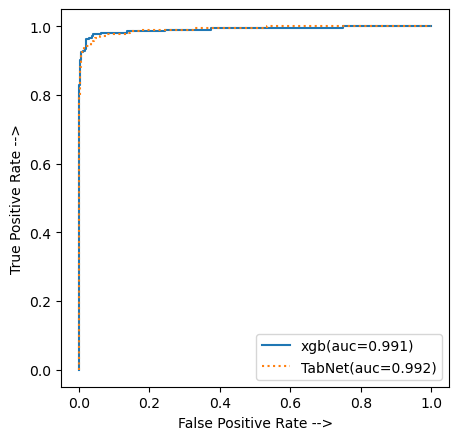

In [12]:
#Plot AUC
xgb_fpr, xgb_tpr, threshold = metrics.roc_curve(y, prob_test_final_XGB)
TabNet_fpr, TabNet_tpr, threshold = metrics.roc_curve(y, prob_test_final_TabNet)

auc_xgb = metrics.auc(xgb_fpr, xgb_tpr)
auc_TabNet_test = metrics.auc(TabNet_fpr, TabNet_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label='xgb(auc=%0.3f)' % auc_xgb)
plt.plot(TabNet_fpr, TabNet_tpr, linestyle='dotted', label='TabNet(auc=%0.3f)' % auc_TabNet_test)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()